In [1]:
import os
%load_ext autoreload
%autoreload 2
import sys


sys.path.append("../../../ukb-dementia-shap/")



from logic.data_processing.data_import import dataload
from logic.data_processing.data_processing import data_proc_main
from logic.analysis.analysis import AnalysisCharts
from logic.ml.classification_shap import IDEARs_funcs
from ukb_utils.utils import basic_funcs

import pandas as pd
import numpy as np
import re

ac=dataload()
dp=data_proc_main()
ml=IDEARs_funcs()
an=AnalysisCharts()


pain_dic=dict({'Not pain-related':'Non Pain','Pain-related - New category "Arthritis-pain"':'Arth'})

def count_nulls(df):
    cols=[]
    non_nulls=[]
    vals_all=[]
    for c in df.columns:
        if c!='eid':
            cols.append(c)
            ns=df[c][pd.notnull(df[c])].shape[0]
            non_nulls.append(ns)
            vals=dict(df[c].value_counts())
            vals_all.append(vals)

    df2=pd.DataFrame({'Column':cols,'non_nulls':non_nulls,'vals_all':vals_all})
    df2.sort_values(by='non_nulls',ascending=False,inplace=True)
    return df2

def search_icd(strings='chronic pain',second_string='',non_strings='xxxxx',string_pat=True):
    mask=(icd10s['disease'].str.contains(strings,regex=True))&(~icd10s['disease'].str.contains(non_strings,regex=True))&\
(icd10s['disease'].str.contains(second_string,regex=True))
    icd10_sub=list(icd10s.loc[mask,'code'])
    icd_df=icd10s.loc[mask,]
    
    if string_pat:
        icd10_sub='|'.join(icd10_sub)
        
    return icd10_sub,icd_df


def process_run(df,depvar='neuropathy',resize=1,remwords='xxxxxxx',resizeratio=20):
    df=ml.col_spec_chars(df=df)
    df=df.loc[pd.notnull(df[depvar]),]

    dropvars=list(set([c for c in df.columns if  re.search(ml.wordsremovePD,c)]+[c for c in df.columns if  re.search(remwords,c)]))

    shap_tuple=ml.run_entire_data_pd(df=df,drops=dropvars,wordsremove='consultant',outfile='test_pain',savefile=False,
    save_featslist=False,runs=2,holdout_ratio=0.5,depvar=depvar,agemin=10,agemax=90,resize=resize,resizeratio=resizeratio,verbose=False)
    
    return shap_tuple

#### All ICD10 codes as per UKB

In [2]:
icd10s=dp.ukb_icd10()

In [3]:
df_pain=pd.read_csv(dp.path+'df_pain.csv')

In [4]:
#df_pain=pd.read_csv(ac.path+ac.inpfile,usecols=paincols)
#df_pain.drop(columns='severity_of_current_abdominal_pain_f21036_0_0').to_csv(dp.path+'df_pain.csv')

#### Pain

In [6]:
pain_types_dic=dict(df_pain['pain_types_experienced_in_last_month_f6159_0_0'].value_counts())

In [142]:
paincols_3mths=['general_pain_for_3_months_f2956_0_0',
 'neckshoulder_pain_for_3_months_f3404_0_0',
 'hip_pain_for_3_months_f3414_0_0',
 'back_pain_for_3_months_f3571_0_0',
 'stomachabdominal_pain_for_3_months_f3741_0_0',
 'knee_pain_for_3_months_f3773_0_0',
 'facial_pains_for_3_months_f4067_0_0']
dic1={'Yes': 1, 'No': 0, 'Do not know': -1, 'Prefer not to answer': -1}
for c in paincols_3mths:
    
    df_pain[c]=df_pain[c].map(dic1)
    df_pain.loc[pd.isnull(df_pain[c]),c]=0



In [143]:
df_pain_3mths=df_pain[['eid','general_pain_for_3_months_f2956_0_0',
 'neckshoulder_pain_for_3_months_f3404_0_0',
 'hip_pain_for_3_months_f3414_0_0',
 'back_pain_for_3_months_f3571_0_0',
 'stomachabdominal_pain_for_3_months_f3741_0_0',
 'knee_pain_for_3_months_f3773_0_0',
 'facial_pains_for_3_months_f4067_0_0']]

In [164]:
mask_head_ache=(df_pain['pain_types_experienced_in_last_month_f6159_0_0']=='Headache')
df_head_ache=df_pain.loc[mask_head_ache,]
df_head_ache['eid']=df_head_ache['eid'].astype(str)

In [121]:
# Types of pain 
head_pain_eids=list(df_pain.loc[df_pain['pain_types_experienced_in_last_month_f6159_0_0']
                                =='Headache','eid'].astype(str))
back_pain_eids=list(df_pain.loc[df_pain['pain_types_experienced_in_last_month_f6159_0_0']
                                == 'Back pain','eid'].astype(str))
mask=(df_pain['pain_types_experienced_in_last_month_f6159_0_0']!= 'None of the above')&\
pd.notnull(df_pain['pain_types_experienced_in_last_month_f6159_0_0'])
pain_eids=list(df_pain.loc[mask,'eid'].astype(str))

#### Chronic Pain predictors

0
Total ohe variables = 1 
Total chronic_pain in data: 1545
Total chronic_pain in data: 1545
3


<Figure size 2000x3000 with 0 Axes>

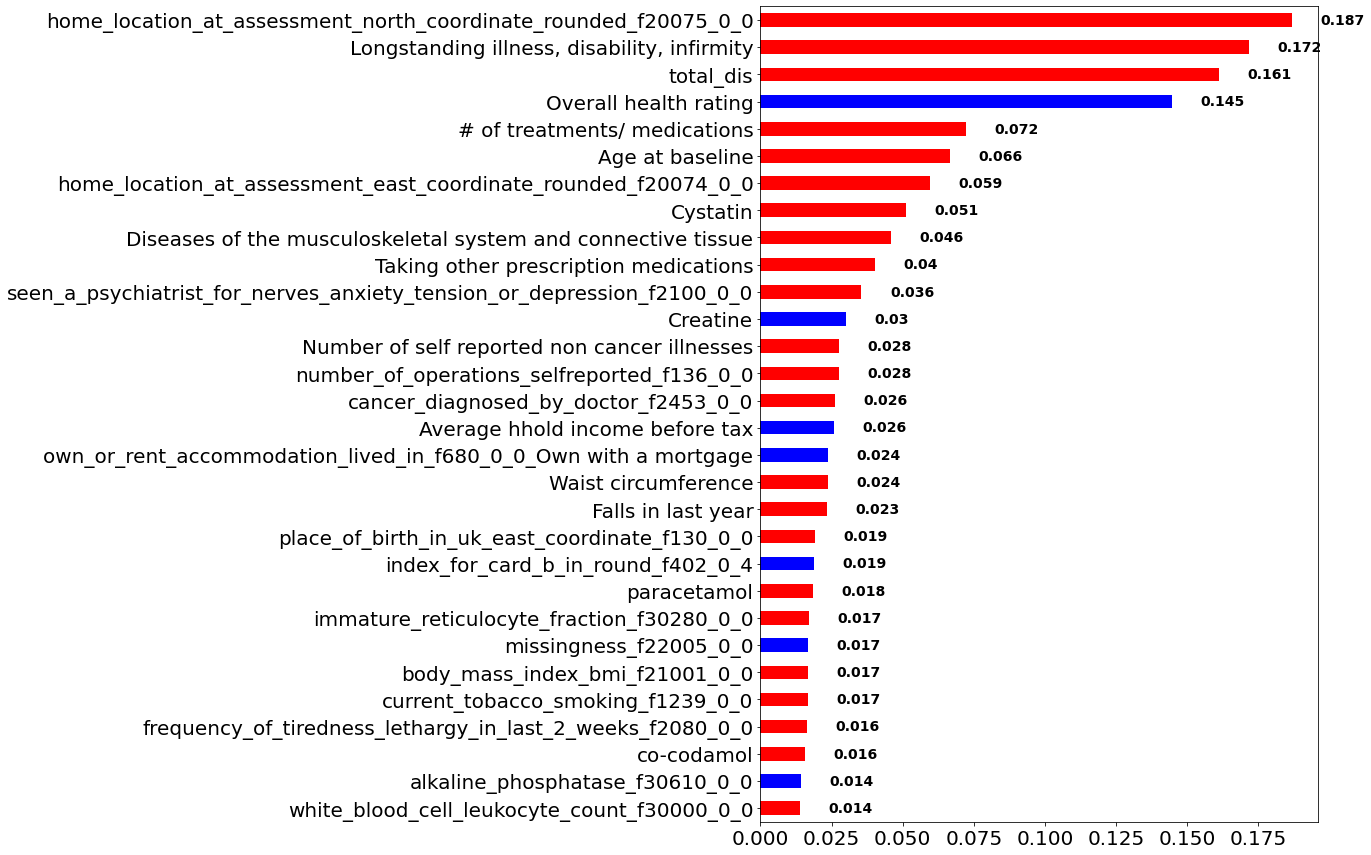

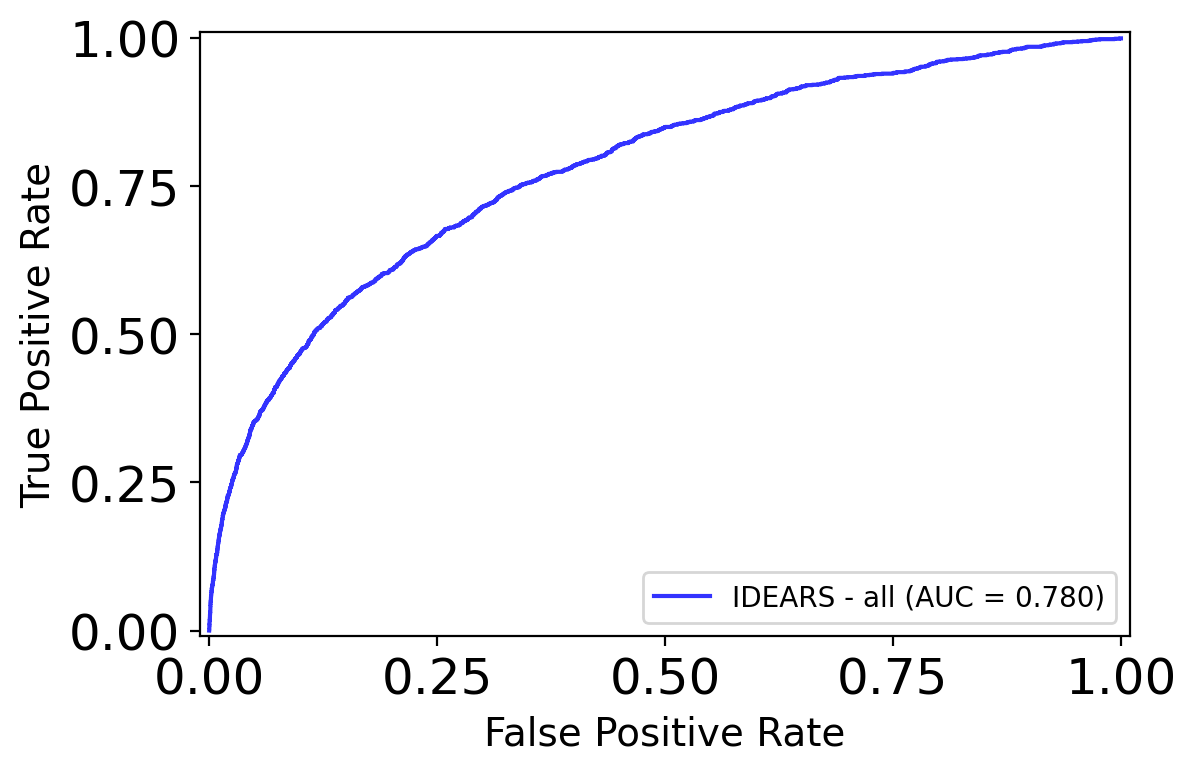

[0.7802357739469516]

In [23]:
df_cp=dp.data_merge_dis(remwords='xxxxx',disease='chronic_pain',icd10s='R521|R522',outfile=None,use_icd10=True,
                 strcont=True)
df_cp.drop(columns='time_to_chronic_pain',inplace=True)
shap_cp=process_run(df=df_cp,depvar='chronic_pain')
feats_all=ml.shapgraphs_tuple(shap_cp,max_disp=30,figname='SHAP IDEARS ENTIRE COHORT chronic_pain')
ml.ROCAUC_tuples(df_out_list=[shap_cp[2]],labels=['IDEARS - all'],cols=['blue'],figname='ROCAUC for chronic pain')

#### ICD10s for Arthritis, Migraine, Lower Back Pain

In [4]:
icd10_diabs=search_icd(strings='diabetes',non_strings='family|screening',string_pat=True)[0]
icd10_poly=search_icd(strings='polyneuropathy',non_strings='xxxxxx',string_pat=True)[0]
icd10_pain=search_icd(strings='pain',non_strings='paint',string_pat=True)[0]
icd10s_arth=search_icd(strings='arthritis',non_strings='xxxx',string_pat=True)[0]
icd10s_sciat=search_icd(strings='sciatica',non_strings='xxxx',string_pat=True)[0]
icd10s_mig=search_icd(strings='migraine',non_strings='xxxx',string_pat=True)[0]

In [23]:
df_poly1=search_icd(strings='polyneuropathy',non_strings='xxxxxx',string_pat=True)[1]

In [24]:
df_poly1

,code,disease
2353,G61,inflammatory polyneuropathy
2357,G619,"inflammatory polyneuropathy, unspecified37"
2359,G620,druginduced polyneuropathy18
2360,G621,alcoholic polyneuropathy9
2361,G622,polyneuropathy due to other toxic agents1
2363,G629,"polyneuropathy, unspecified558"
2364,G63,polyneuropathy in diseases classified elsewhere
2365,G631,polyneuropathy in neoplastic disease2
2366,G632,diabetic polyneuropathy19
2367,G633,polyneuropathy in other endocrine and metaboli...


In [13]:
df_poly=dp.data_merge_dis(remwords='xxxxx',disease='polyneuropathy',icd10s=icd10_poly,outfile=None,use_icd10=True,
                 strcont=True)
poly_eids=list(df_poly.loc[df_poly['polyneuropathy']==1,'eid'].astype(str))

In [4]:
df_cp=dp.data_merge_dis(remwords='xxxxx',disease='chronic_pain',icd10s='R521|R522',outfile=None,use_icd10=True,
                 strcont=True)
cp_eids=list(df_cp.loc[df_cp['chronic_pain']==1,'eid'].astype(str))

0
Total ohe variables = 1 


#### Diabetes and polyneuropathy/ chronic pain

In [5]:
cp_eids=list(df_cp.loc[df_cp['chronic_pain']==1,'eid'].astype(str))

In [7]:
df_diab=dp.data_merge_dis(remwords='xxxxx',disease='diabetes',icd10s=icd10_diabs,outfile=None,use_icd10=True,
                 strcont=True,bef=True,years=0)

0
Total ohe variables = 1 


In [8]:
df_diab=df_diab.loc[df_diab['diabetes']==1,]
df_diab['chronic_pain']=0
df_diab.loc[df_diab['eid'].isin(cp_eids),'chronic_pain']=1

In [14]:
df_diab['polyneuropathy']=0
df_diab.loc[df_diab['eid'].isin(poly_eids),'polyneuropathy']=1
df_diab['polyneuropathy'].sum()

829

In [19]:
dp.findcols(df_diab,'time_to')

['time_to_complete_round_f400_0_1',
 'time_to_complete_round_f400_0_2',
 'mean_time_to_correctly_identify_matches_f20023_0_0']

In [18]:
df_diab.drop(columns=['time_since_diabetes','diabetes'],inplace=True)

Total polyneuropathy in data: 829
Total polyneuropathy in data: 829
3


<Figure size 2000x3000 with 0 Axes>

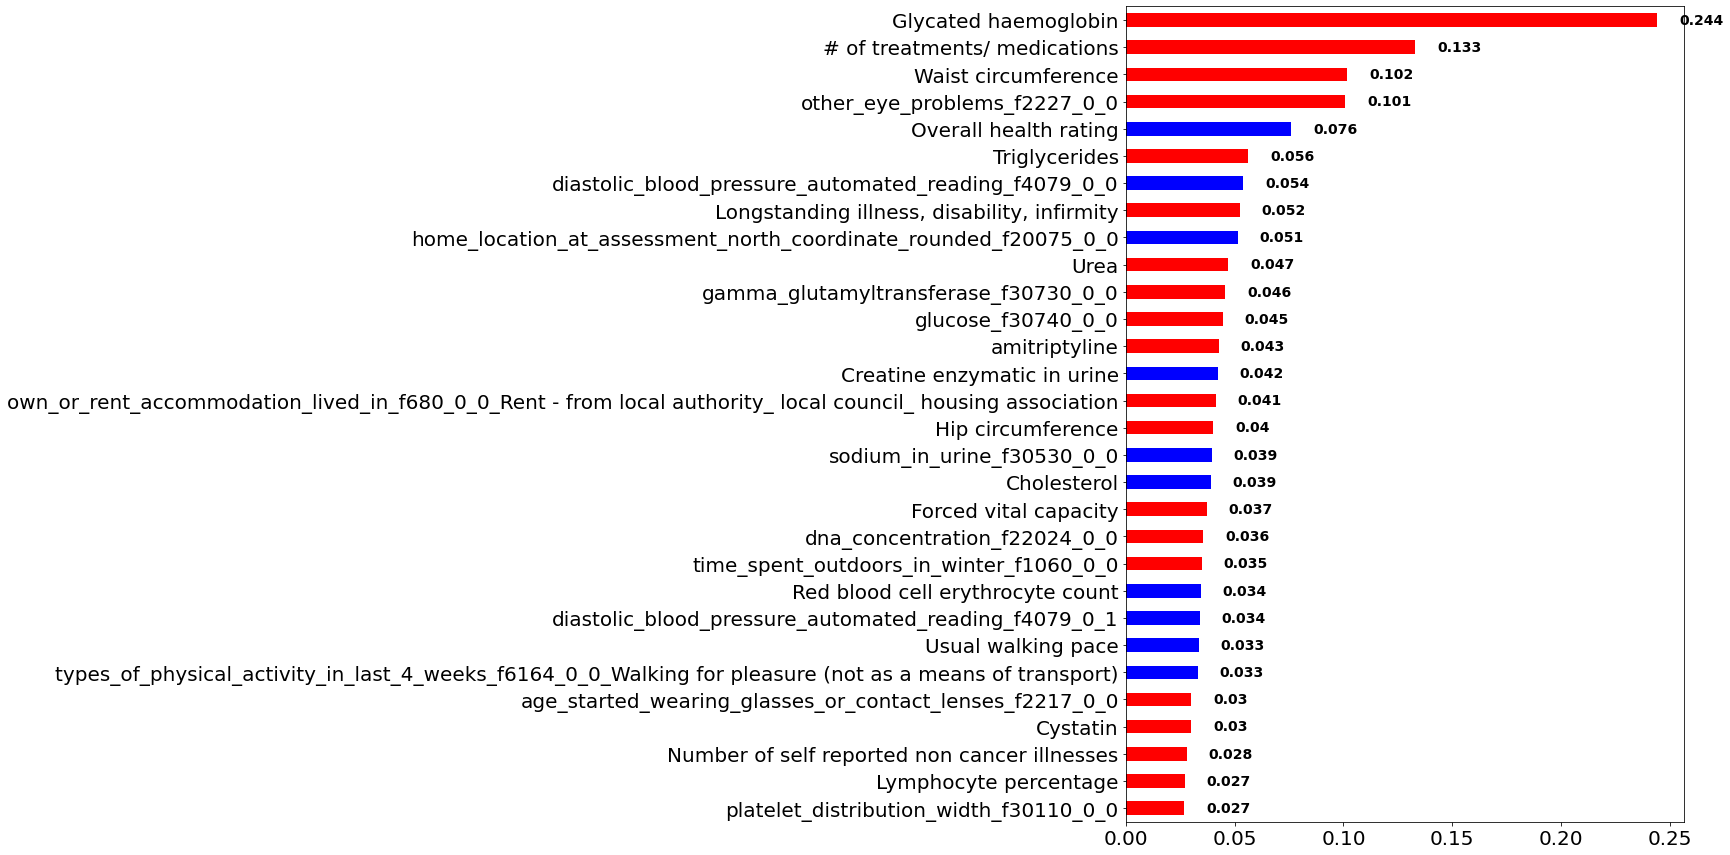

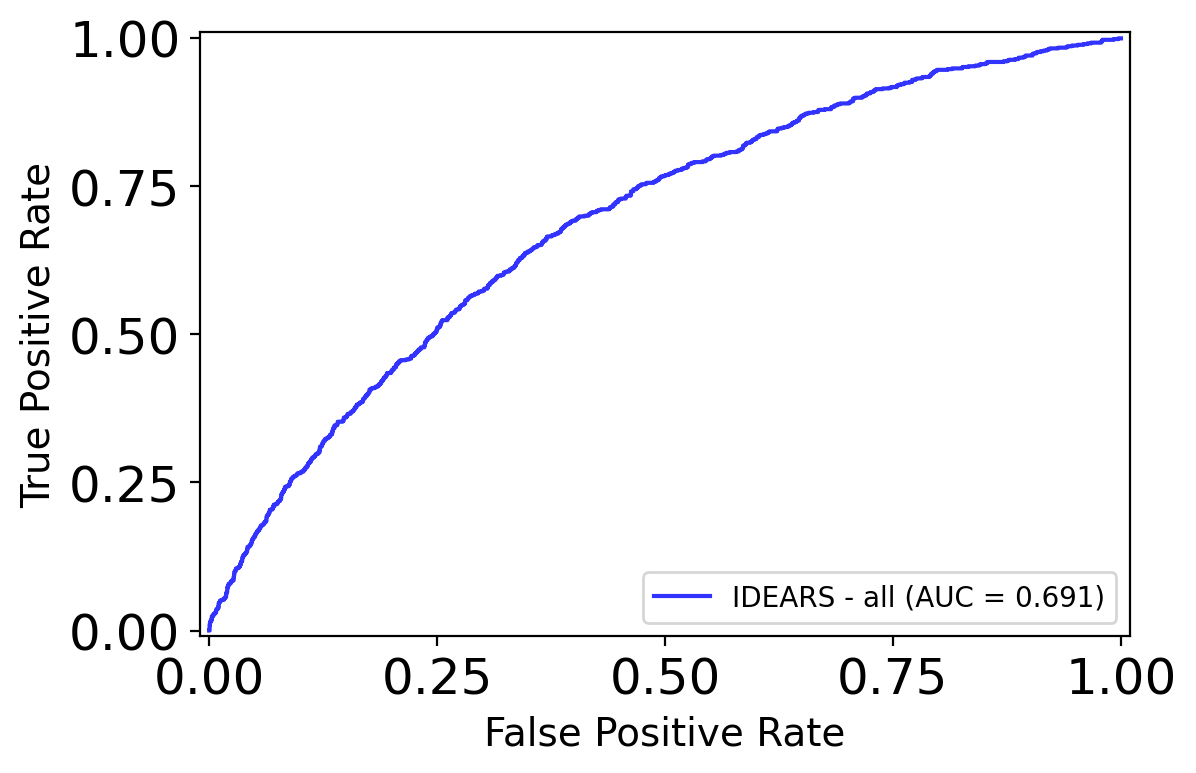

[0.6905359518308478]

In [22]:
shap_poly_diab=process_run(df=df_diab,depvar='polyneuropathy',resize=1,resizeratio=5,remwords='diabetes')
feats_all=ml.shapgraphs_tuple(shap_poly_diab,max_disp=30,figname='SHAP IDEARS ENTIRE COHORT polyneuro in diabetes')
ml.ROCAUC_tuples(df_out_list=[shap_poly_diab[2]],labels=['IDEARS - all'],cols=['blue'],figname='ROCAUC polyneuro in diabetes')

In [76]:
df_diab1=search_icd(strings='diabetes',non_strings='family|screening',string_pat=True)[1]

In [78]:
df_mg1=search_icd(strings='migraine',non_strings='xxxx',string_pat=True)[1]

In [138]:
icd10_als=search_icd(strings='lateral',string_pat=True)[1]

In [31]:
chk=search_icd(strings='arthritis',non_strings='xxxx',string_pat=True)[1]

In [83]:
icd10s_rheum=search_icd(strings='arthritis',second_string='rheumatoid',non_strings='xxxx',string_pat=True)[0]
icd10s_ost=search_icd(strings='osteo',second_string='arth',non_strings='xxxx',string_pat=True)[0]

#### Joint Pain

In [ ]:
back_pain_for_3_months_f3571_0_0

In [27]:
def spec_pain_eids(df=df_pain,pain_vars=['general_pain_for_3_months_f2956_0_0'],var_pain='gen_pain'):
    df1=df[['eid']+pain_vars]

    for v in pain_vars:
        df1.loc[df1[v]=='Yes',v]=1
        df1.loc[df1[v]!=1,v]=0
        df1[v]=pd.to_numeric(df1[v])
        
    df1[var_pain]=df1[pain_vars].max(axis=1)
    
    pain_eids=list(df1.loc[df1[var_pain]==1,'eid'].astype(str))
    
    return pain_eids



In [34]:
joint_pain=['hip_pain_for_3_months_f3414_0_0','neckshoulder_pain_for_3_months_f3404_0_0','knee_pain_for_3_months_f3773_0_0']
joint_pain_eids=spec_pain_eids(df=df_pain,pain_vars=joint_pain)
gen_pain=['general_pain_for_3_months_f2956_0_0']
gen_pain_eids=spec_pain_eids(df=df_pain,pain_vars=gen_pain)
back_pain=['back_pain_for_3_months_f3571_0_0']
back_pain_eids=spec_pain_eids(df=df_pain,pain_vars=back_pain)

In [59]:
headache_eids=list(df_pain.loc[df_pain['pain_types_experienced_in_last_month_f6159_0_0']=='Headache','eid'].astype(str))

#### General pain 3 mths

In [68]:

df_poly=dp.disease_labels_ICD10s2(icd10s=icd10_poly,disease='polyneuropathy',out='test.parquet',strcont=True,bef=False,
		years=2,outfile=False)
df_pain_icd=dp.disease_labels_ICD10s2(icd10s=icd10_pain,disease='pain',out='test.parquet',strcont=True,bef=True,
		years=2,outfile=False)
df_sciat=dp.disease_labels_ICD10s2(icd10s=icd10s_sciat,disease='sciatica',out='test.parquet',strcont=True,bef=False,
		years=2,outfile=False)
df_mig=dp.disease_labels_ICD10s2(icd10s=icd10s_mig,disease='migraine',out='test.parquet',strcont=True,bef=False,
		years=2,outfile=False)



In [71]:
df_poly=dp.disease_labels_ICD10s2(icd10s=icd10_poly,disease='polyneuropathy',out='test.parquet',strcont=True,bef=True,
		years=0,outfile=False)

In [75]:
icd10_poly

'G61|G619|G620|G621|G622|G629|G63|G631|G632|G633|G635|G636|G638'

In [74]:
df_poly[0].loc[df_poly[0]['polyneuropathy']==1,]

,eid,polyneuropathy_date,date_assess,time_since_polyneuropathy,polyneuropathy
11,1006225,2004-10-06,2008-09-29,3.980835,1
13,1008261,2004-03-01,2009-01-24,4.900753,1
18,1012809,2007-06-12,2009-03-27,1.790554,1
27,1018471,2001-07-02,2010-01-29,8.577687,1
28,1018977,1999-06-27,2008-07-03,9.018480,1
...,...,...,...,...,...
4847,5980273,2003-11-12,2008-03-03,4.306639,1
4850,5984038,2000-07-11,2008-07-18,8.019165,1
4851,5984364,2006-05-09,2010-05-19,4.027379,1
4874,6014593,2009-05-14,2009-11-02,0.470910,1


#### Headache and migraine

In [7]:
df_mig=dp.data_merge_dis(remwords='xxxxx',disease='mig',icd10s=icd10s_mig,outfile=None,use_icd10=True,
                 strcont=True,bef=True,years=0)

0
Total ohe variables = 1 


In [8]:
print(df_mig.shape)
print(df_mig['mig'].sum())

(462530, 1732)
1502.0


1502.0
Total mig in data: 1502
Total mig in data: 1502
3


<Figure size 2000x3000 with 0 Axes>

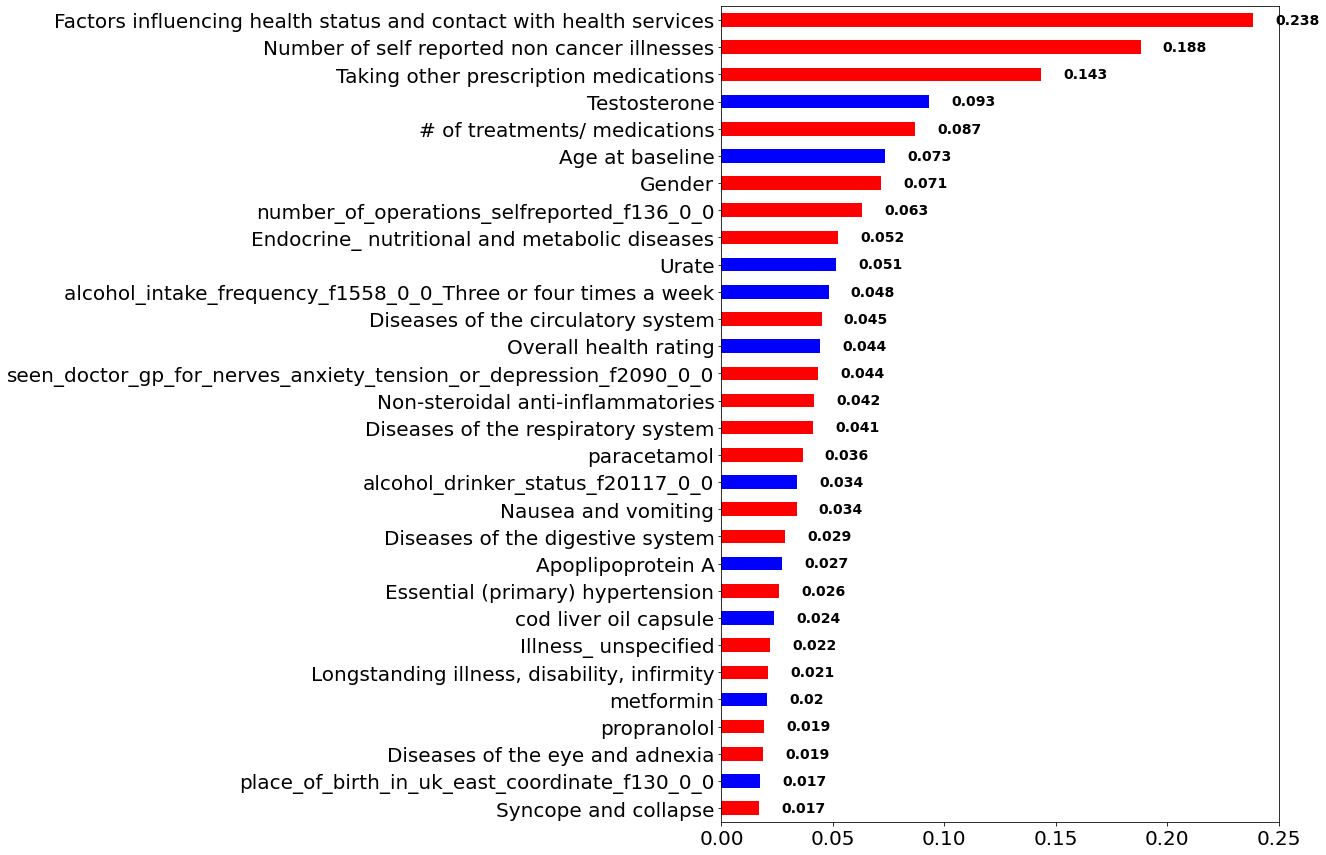

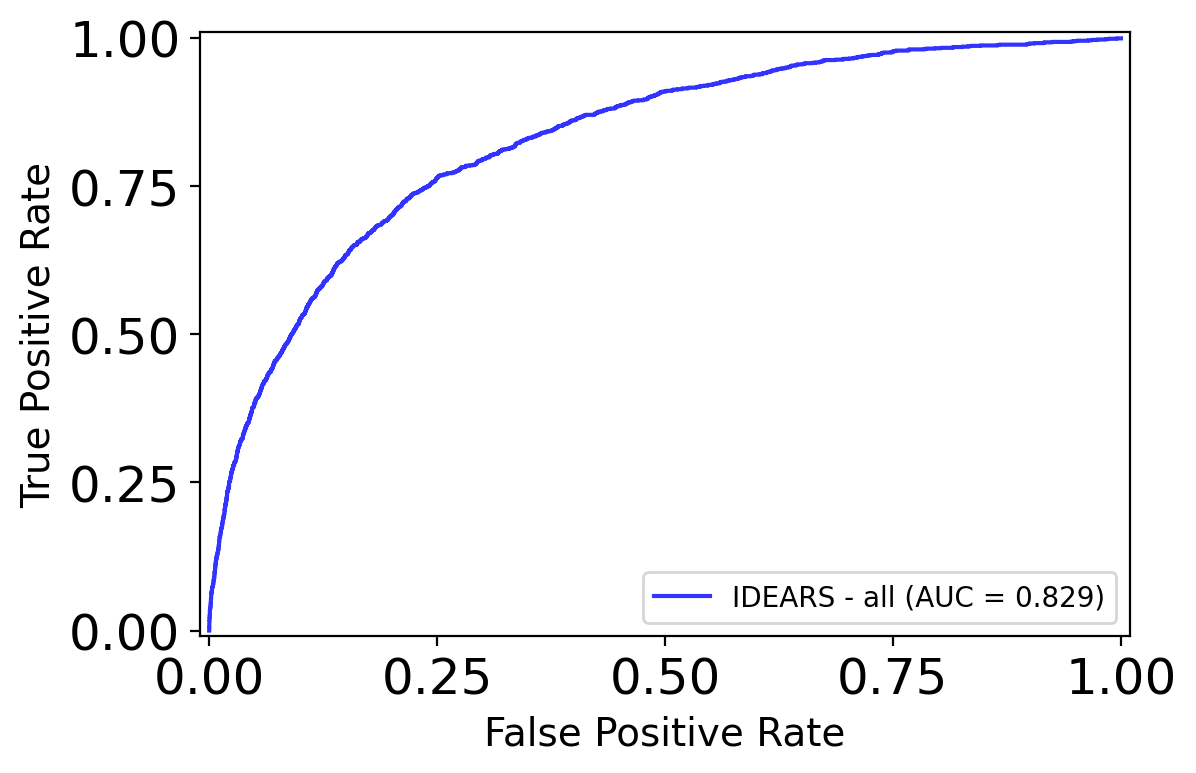

[0.8286390892923948]

In [10]:
head_control=False

if head_control:
    df_mig['headache']=0
    df_mig.loc[df_mig['eid'].isin(headache_eids),'headache']=1
    df_mig=df_mig.loc[df_mig['headache']==1,]
df_mig.drop(columns=['time_since_mig'],inplace=True)

print(df_mig['mig'].sum())


#df_sciat.drop(columns=['time_since_sci','back_pain_3mths'],inplace=True)
shap_mig=process_run(df=df_mig,depvar='mig',resize=1,remwords='pain|Headache|headache|migraine|Migraine|nervous system|total_dis\
|abnormal clinical')
feats_all=ml.shapgraphs_tuple(shap_mig,max_disp=30,figname='SHAP IDEARS ENTIRE COHORT migraine')
ml.ROCAUC_tuples(df_out_list=[shap_mig[2]],labels=['IDEARS - all'],cols=['blue'],figname='ROCAUC for migraine')

#### Back pain and sciatica 

In [5]:
df_sciat=dp.data_merge_dis(remwords='xxxxx',disease='sci',icd10s=icd10s_sciat,outfile=None,use_icd10=True,
                 strcont=True,bef=True,years=0)

0
Total ohe variables = 1 


In [6]:
print(df_sciat['sci'].sum())

1437.0


Total sci in data: 1437
Total sci in data: 1437
3


<Figure size 2000x3000 with 0 Axes>

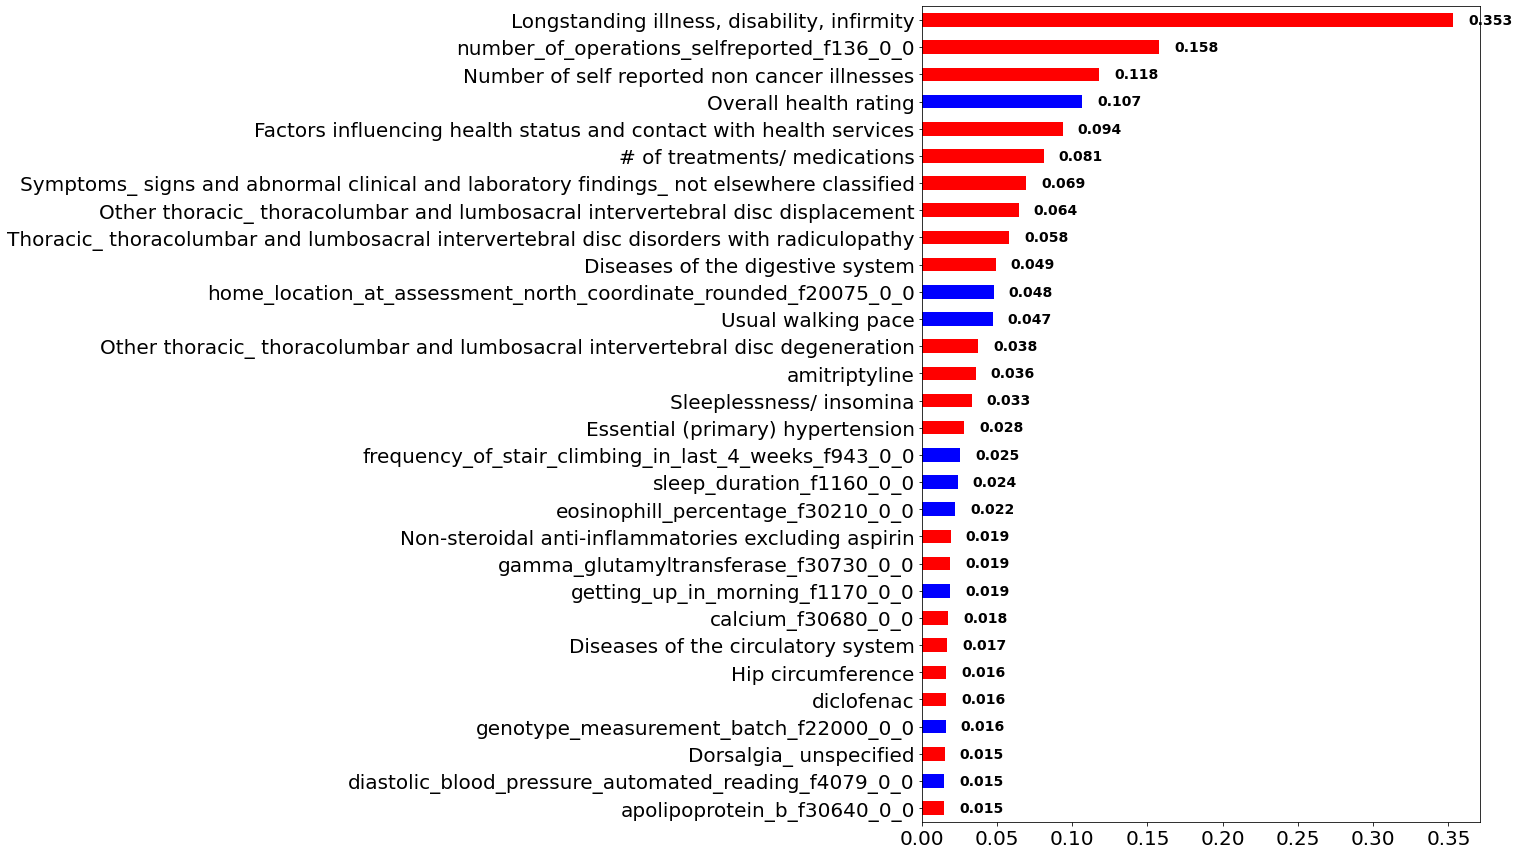

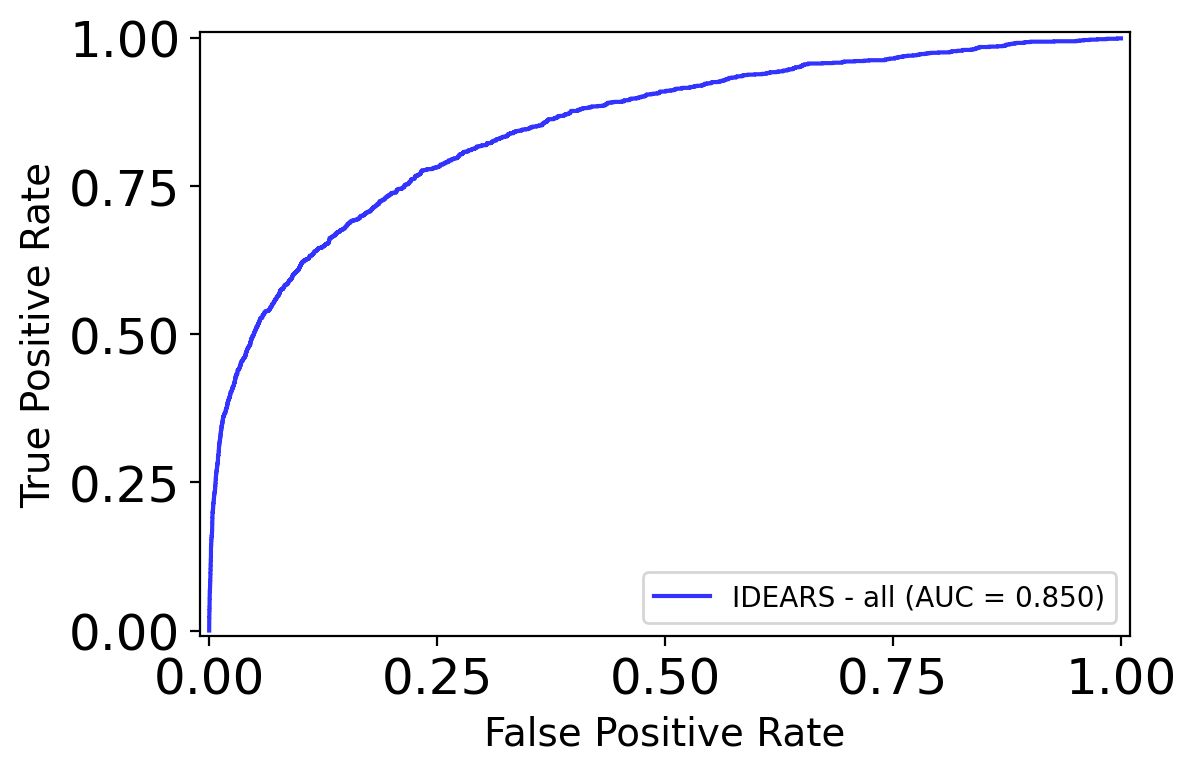

[0.8499939260829759]

In [8]:
df_sciat.drop(columns='time_since_sci',inplace=True)

back_control=False

if back_control:
    df_sciat['back_pain_3mths']=0
    df_sciat.loc[df_sciat['eid'].isin(back_pain_eids),'back_pain_3mths']=1
    df_sciat=df_sciat.loc[df_sciat['back_pain_3mths']==1,]

#df_sciat.drop(columns=['time_since_sci','back_pain_3mths'],inplace=True)
shap_bpain_sciat=process_run(df=df_sciat,depvar='sci',resize=1,remwords='pain|Sciatica|sciatica|musculoskeletal|M54|total_dis')
feats_all=ml.shapgraphs_tuple(shap_bpain_sciat,max_disp=30,figname='SHAP IDEARS ENTIRE COHORT sciatica')
ml.ROCAUC_tuples(df_out_list=[shap_bpain_sciat[2]],labels=['IDEARS - all'],cols=['blue'],figname='ROCAUC for sciatica')

#### Diabetes and general pain for >3 months

In [16]:
df_diab=dp.data_merge_dis(remwords='xxxxx',disease='diabetes',icd10s=icd10_diabs,outfile=None,use_icd10=True,
                 strcont=True,bef=True,years=0)


0
Total ohe variables = 1 


In [17]:
df_diab=df_diab.loc[df_diab['diabetes']==1,]

In [22]:
df_diab.shape

(11391, 1731)

Total general_pain in data: 558
Total general_pain in data: 558
3


<Figure size 2000x3000 with 0 Axes>

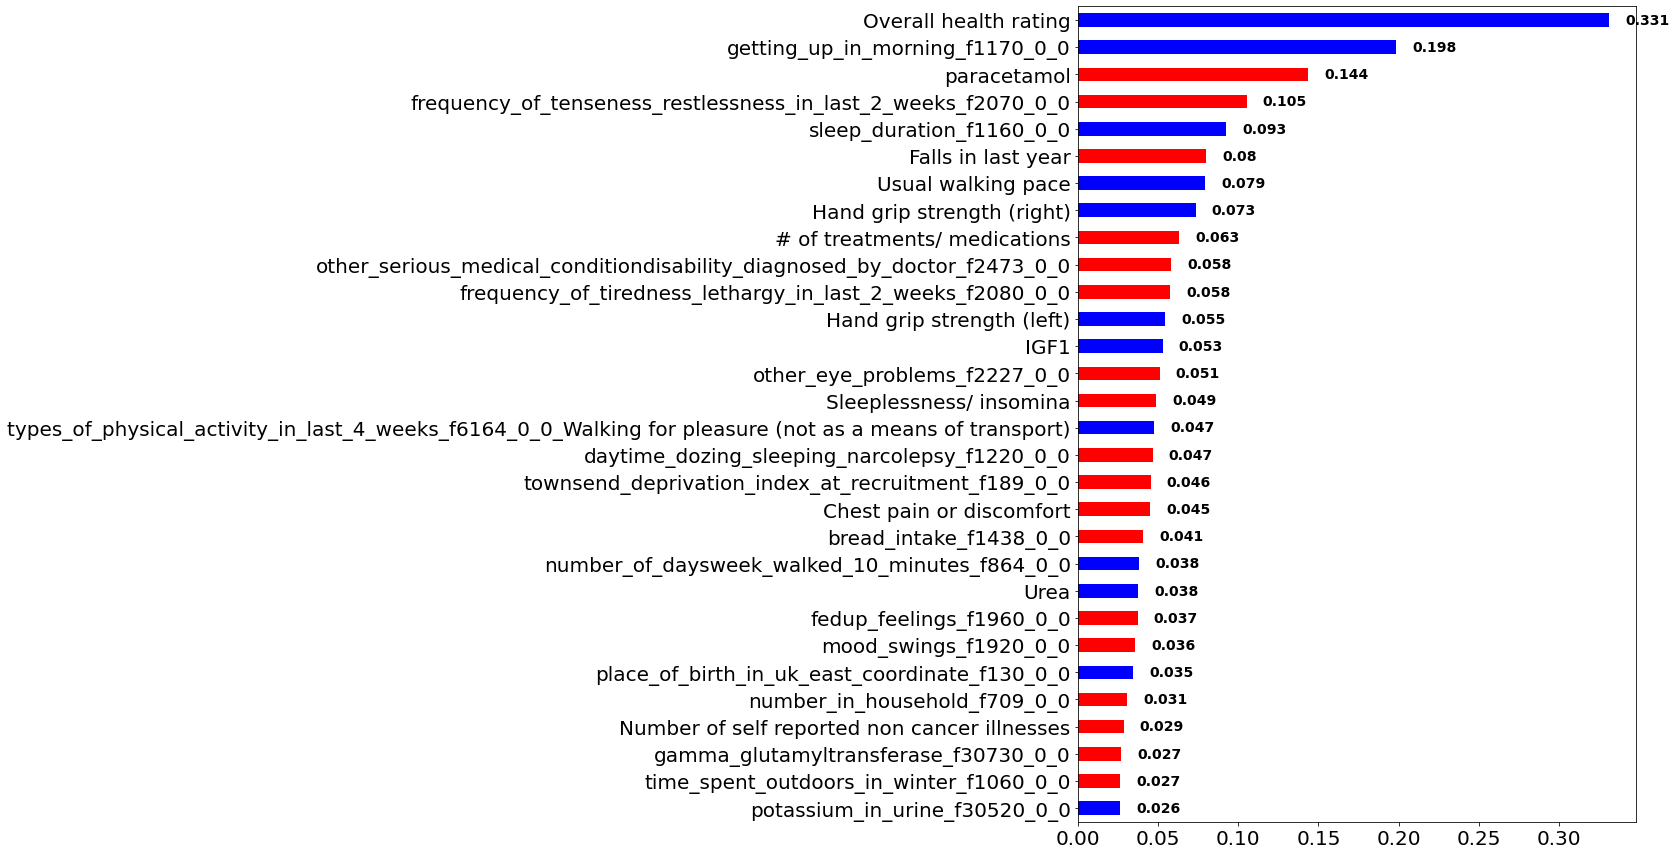

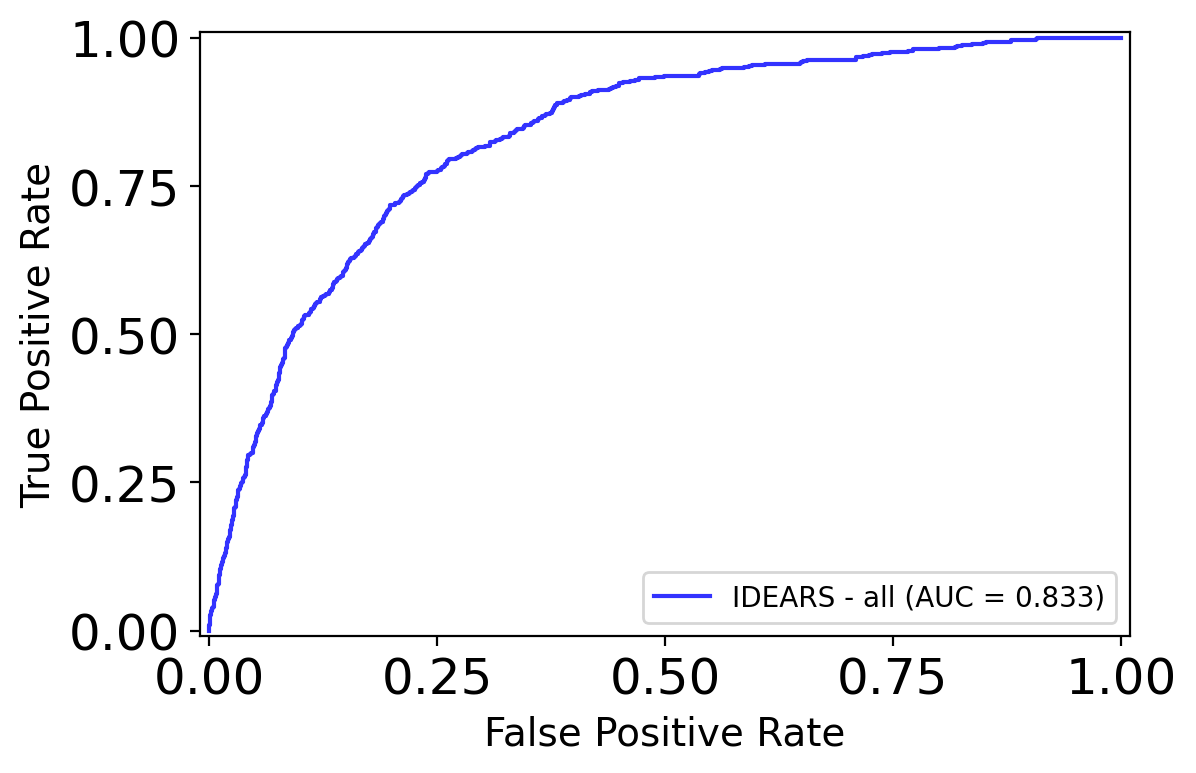

[0.8334433551457782]

In [21]:
df_diab['general_pain']=0
df_diab.loc[df_diab['eid'].isin(gen_pain_eids),'general_pain']=1

df_diab.drop(columns=['time_since_diabetes','diabetes'],inplace=True)
shap_diab_gpain=process_run(df=df_diab,depvar='general_pain',resize=0,remwords='diabetes')
feats_all=ml.shapgraphs_tuple(shap_diab_gpain,max_disp=30,figname='SHAP IDEARS ENTIRE COHORTfor gen pain in diabetes')
ml.ROCAUC_tuples(df_out_list=[shap_diab_gpain[2]],labels=['IDEARS - all'],cols=['blue'],figname='ROCAUC for  gen pain in diabetes')

In [20]:
df_diab['general_pain'].sum()

558

#### Arthritis joint pain

In [116]:
df_arth_bef=dp.data_merge_dis(remwords='xxxxx',disease='arthritis',icd10s=icd10s_arth,outfile=None,use_icd10=True,
                 strcont=True,bef=True,years=0)

0
Total ohe variables = 1 


In [122]:
df_arth_bef=df_arth_bef.loc[df_arth_bef['arthritis']==1,]

In [128]:
df_arth_bef['joint_pain_3mths']=0
df_arth_bef.loc[df_arth_bef['eid'].isin(joint_pain_eids),'joint_pain_3mths']=1

In [135]:
df_arth_bef['joint_pain_3mths'].value_counts()

1    3778
0    2741
Name: joint_pain_3mths, dtype: int64

Total joint_pain_3mths in data: 3778
Total joint_pain_3mths in data: 3778
3


<Figure size 2000x3000 with 0 Axes>

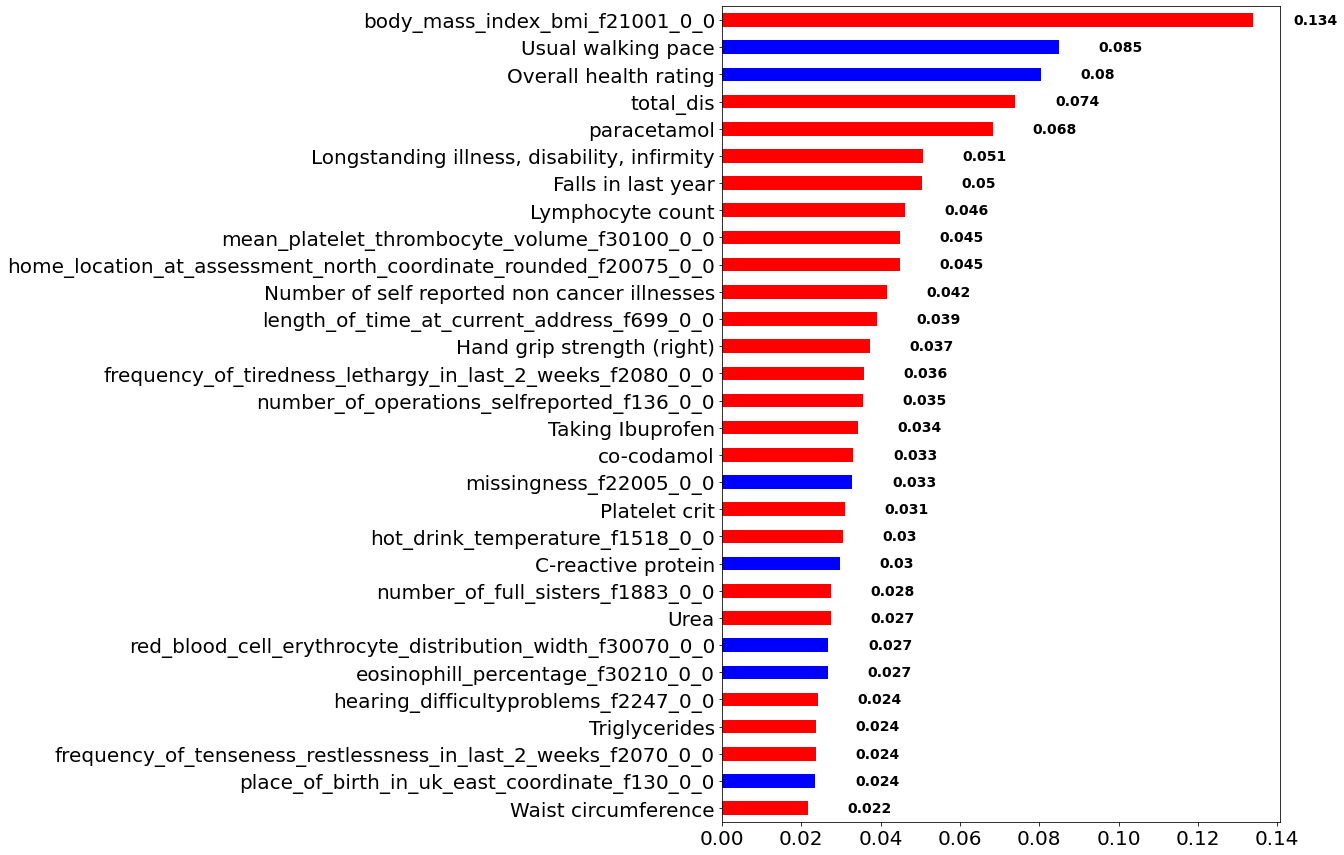

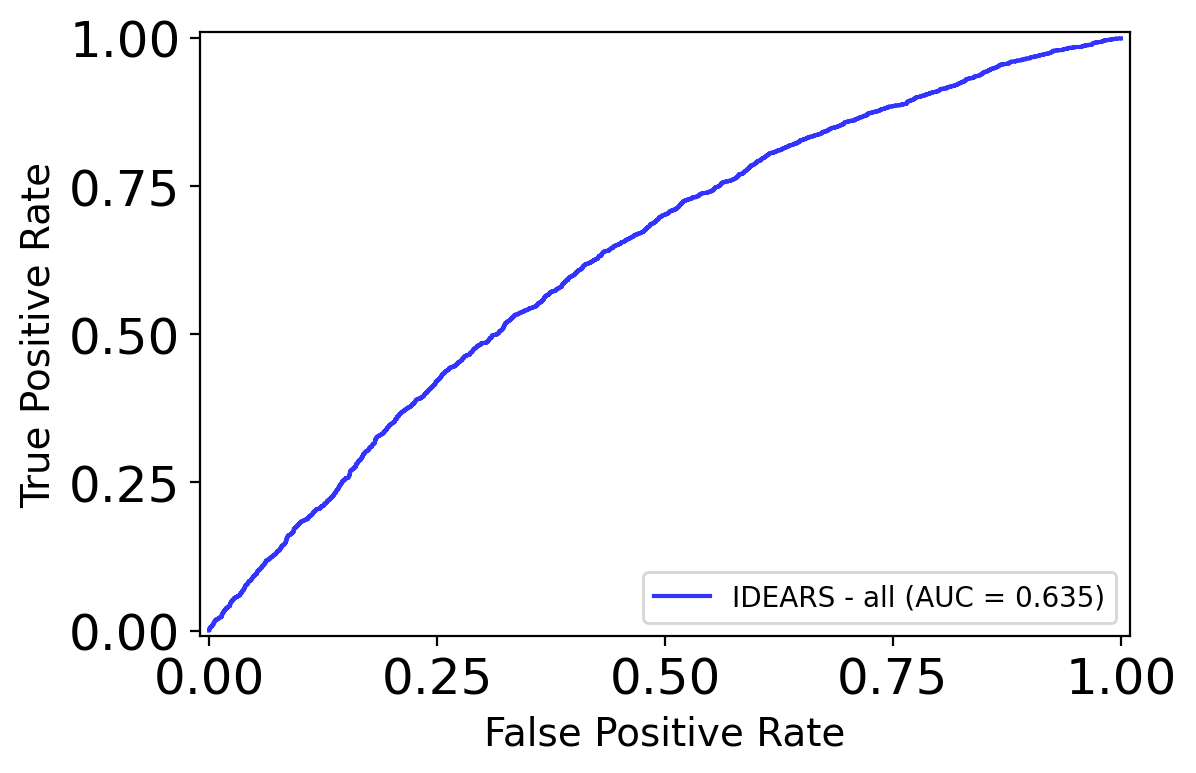

[0.6349906102560734]

In [134]:
df_arth_bef['joint_pain_3mths'].value_counts()

#df_arth_bef.drop(columns=['time_since_arthritis','arthritis'],inplace=True)
shap_arth_jpain=process_run(df=df_arth_bef,depvar='joint_pain_3mths',resize=0,remwords='arthritis')
feats_all=ml.shapgraphs_tuple(shap_arth_jpain,max_disp=30,figname='SHAP IDEARS ENTIRE COHORTfor joint pain in arthritis')
ml.ROCAUC_tuples(df_out_list=[shap_arth_jpain[2]],labels=['IDEARS - all'],cols=['blue'],figname='ROCAUC for joint pain in arthritis')

#### Arthritis Predictors

In [5]:
df_arth=dp.data_merge_dis(remwords='xxxxx',disease='arthritis',icd10s=icd10s_arth,outfile=None,use_icd10=True,
                 strcont=True,bef=False,years=2)

0
Total ohe variables = 1 


In [51]:
df_rem_arth=dp.data_merge_dis(remwords=icd10s_arth+'|arthritis',disease='rheum_arth',icd10s=icd10s_rheum,outfile=None,use_icd10=True,
                 strcont=True,bef=False,years=2)

0
Total ohe variables = 1 


In [56]:
df_rem_arth2=ml.agenorm_df(df=df_rem_arth,depvar='rheum_arth',max_age=70,red_fact=2)

In [87]:
df_ost_arth=dp.data_merge_dis(remwords=icd10s_arth+'|arthritis',disease='ost_arth',icd10s=icd10s_ost,outfile=None,use_icd10=True,
                 strcont=True,bef=False,years=2)

0
Total ohe variables = 1 


In [90]:
df_ost_arth=ml.agenorm_df(df=df_ost_arth,depvar='ost_arth',max_age=70,red_fact=1)

Total ost_arth in data: 435
Total ost_arth in data: 435
3


<Figure size 2000x3000 with 0 Axes>

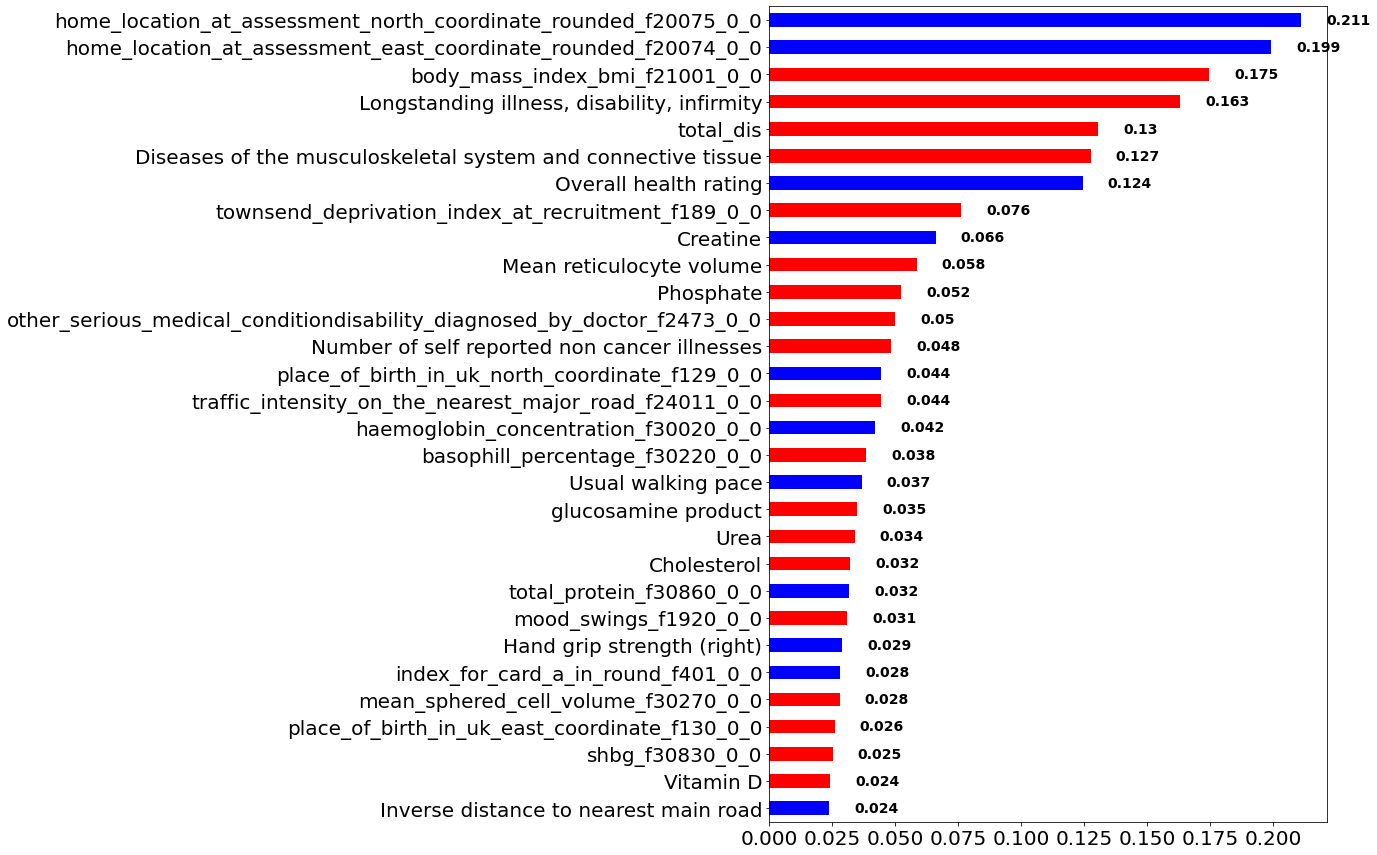

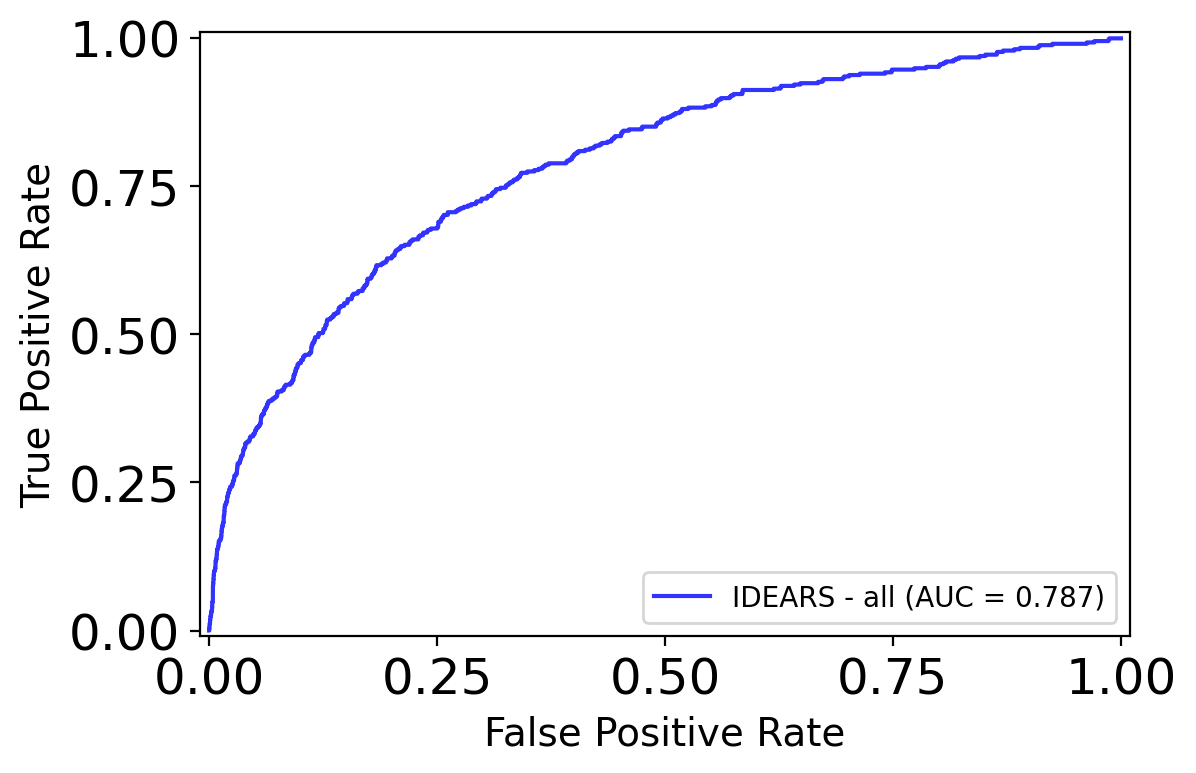

[0.78698249831664]

In [93]:
df_ost_arth.drop(columns='time_to_ost_arth',inplace=True)
shap_ost_arth=process_run(df=df_ost_arth,depvar='ost_arth')
feats_all=ml.shapgraphs_tuple(shap_ost_arth,max_disp=30,figname='SHAP IDEARS ENTIRE COHORT ost arthritis age norm')
ml.ROCAUC_tuples(df_out_list=[shap_ost_arth[2]],labels=['IDEARS - all'],cols=['blue'],figname='ROCAUC for ost arthritis age norm')

Total rheum_arth in data: 3045
Total rheum_arth in data: 3045
3


<Figure size 2000x3000 with 0 Axes>

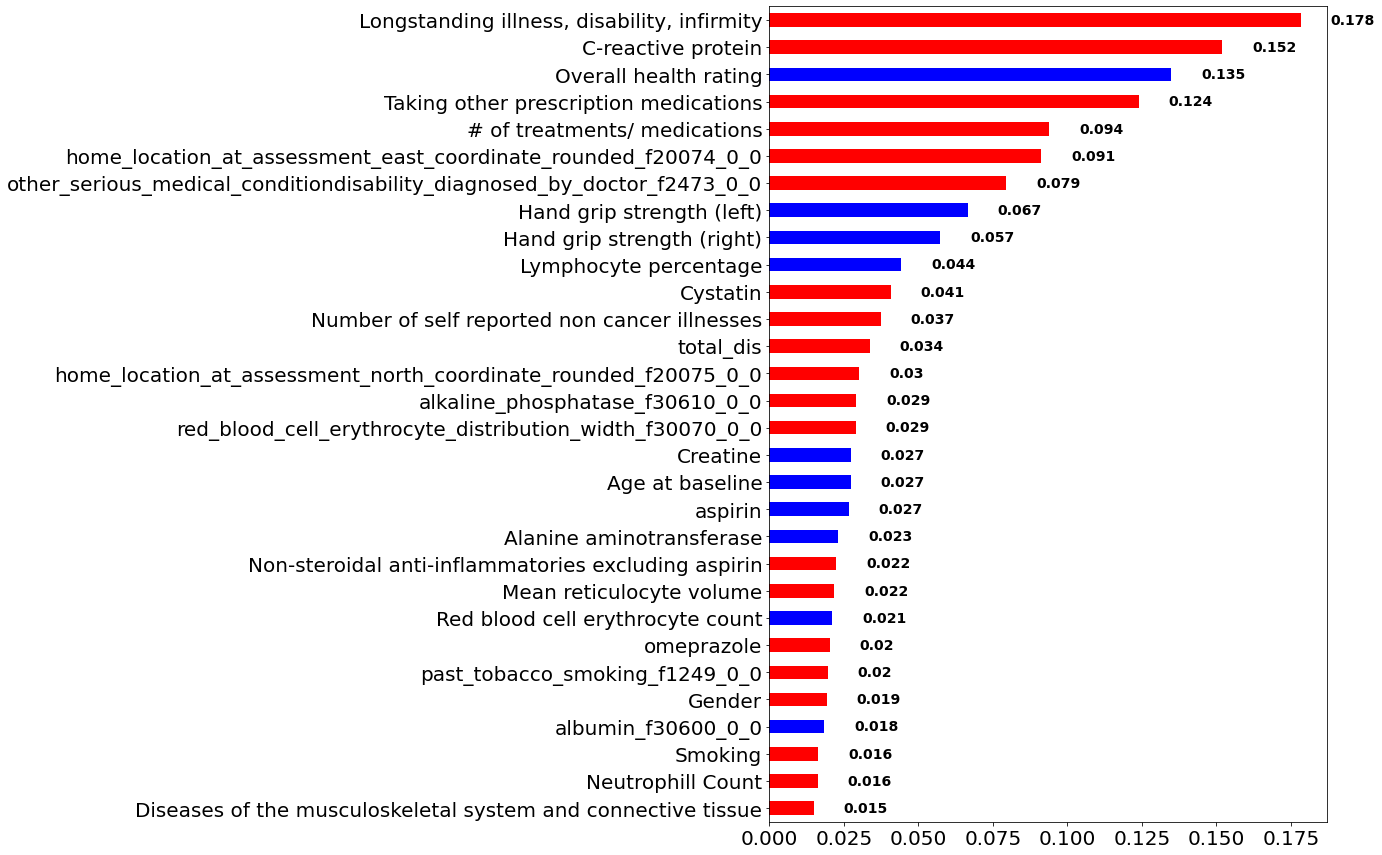

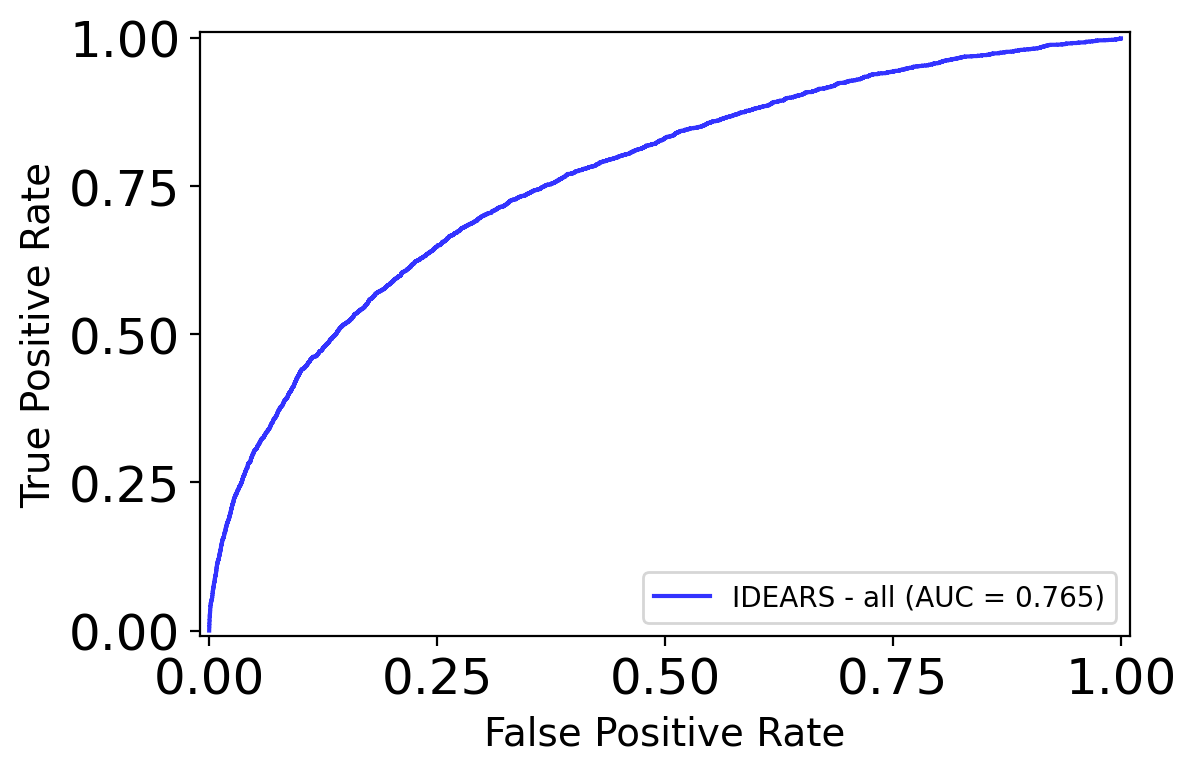

[0.765330029799472]

In [59]:
#df_rem_arth2.drop(columns='time_to_rheum_arth',inplace=True)
shap_rem_arth=process_run(df=df_rem_arth2,depvar='rheum_arth')
feats_all=ml.shapgraphs_tuple(shap_rem_arth,max_disp=30,figname='SHAP IDEARS ENTIRE COHORT rheum arthritis age norm')
ml.ROCAUC_tuples(df_out_list=[shap_rem_arth[2]],labels=['IDEARS - all'],cols=['blue'],figname='ROCAUC for rheum arthritis age norm')

In [25]:
df_arth2=ml.agenorm_df(df=df_arth,depvar='arthritis',max_age=70,red_fact=10)

Total arthritis in data: 2777
Total arthritis in data: 2777
3


<Figure size 2000x3000 with 0 Axes>

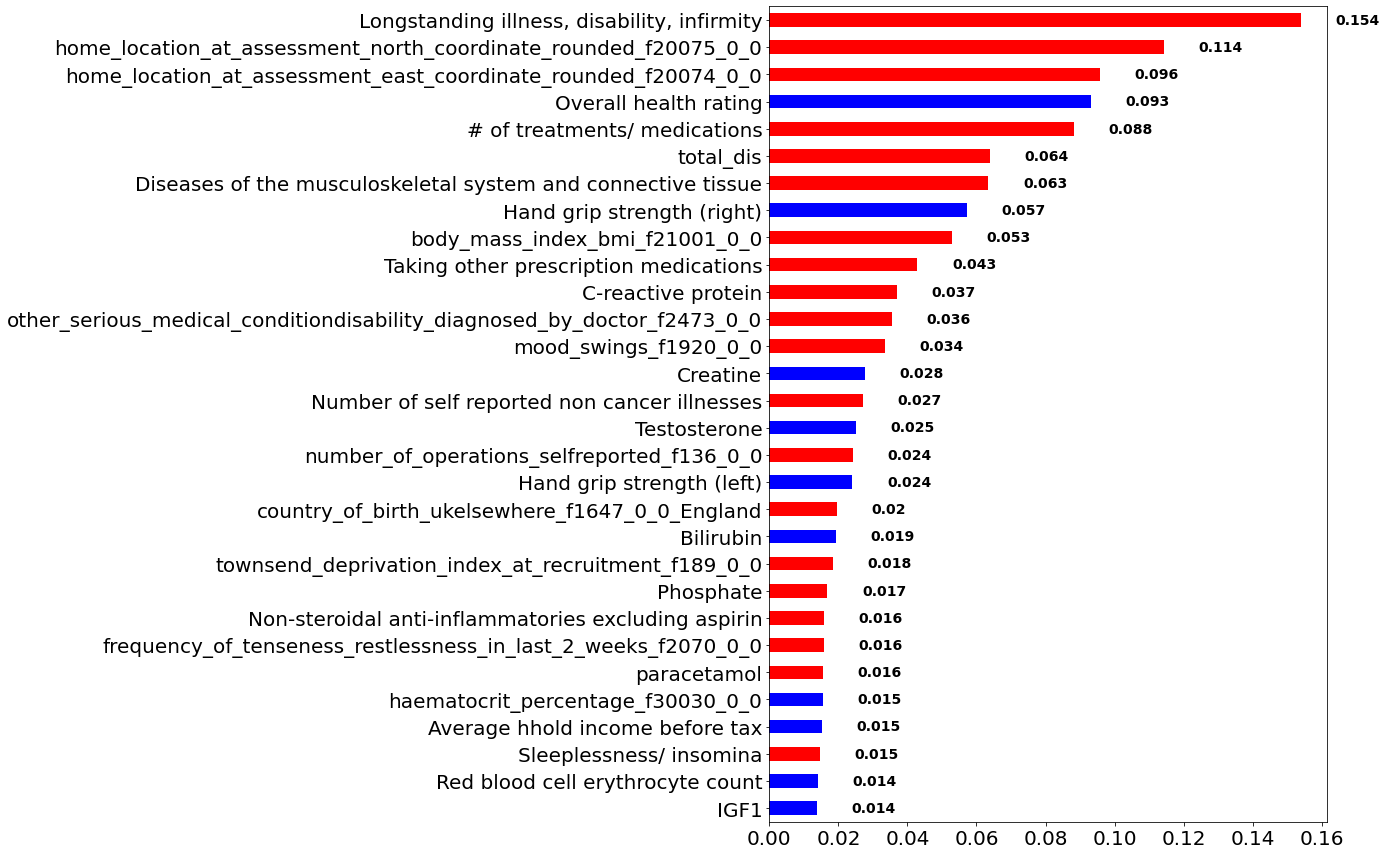

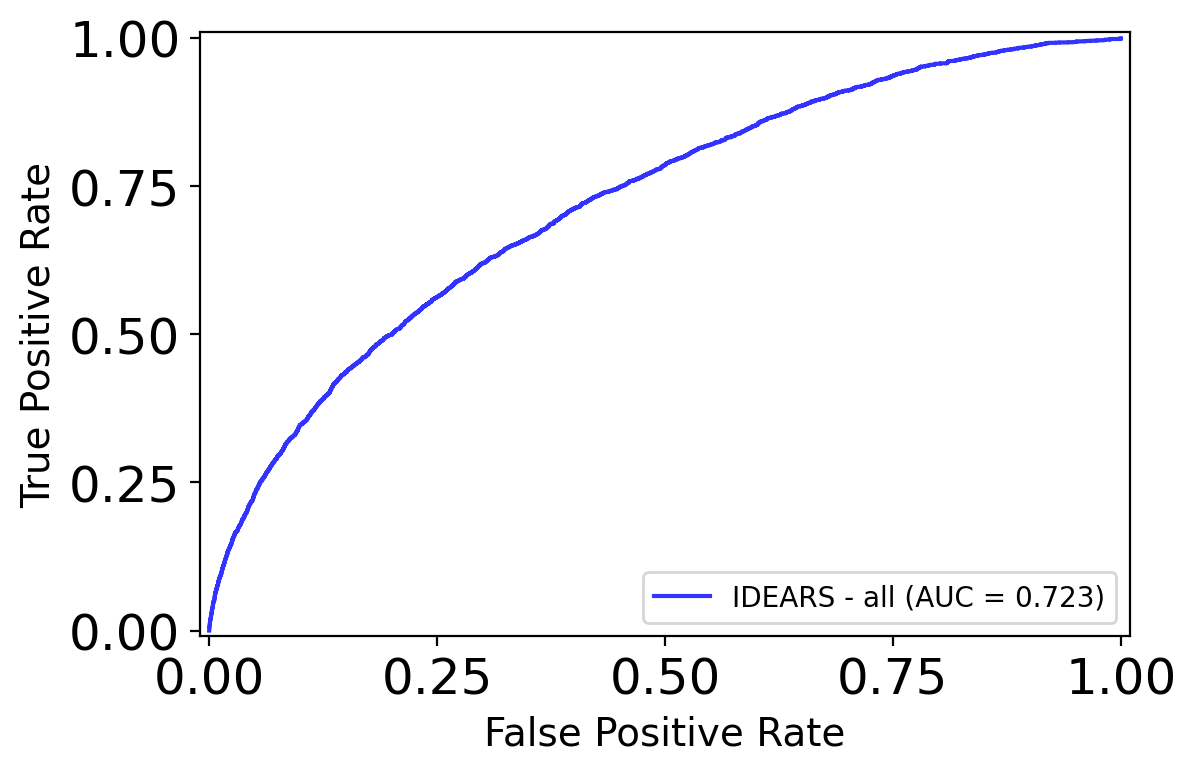

[0.7230561662489929]

In [29]:
df_arth2.drop(columns='time_to_arthritis',inplace=True)
shap_arth=process_run(df=df_arth2,depvar='arthritis')
feats_all=ml.shapgraphs_tuple(shap_arth,max_disp=30,figname='SHAP IDEARS ENTIRE COHORT arthritis age norm')
ml.ROCAUC_tuples(df_out_list=[shap_arth[2]],labels=['IDEARS - all'],cols=['blue'],figname='ROCAUC for arthritis age norm')

In [21]:
fact=int(min([bal_dict[x] for x in bal_dict]))

In [22]:

grouped = df_ctrl.groupby(normvar, group_keys=False)

In [23]:
df_ctrl2=df_ctrl.loc[grouped.apply(lambda x: x.sample(x['samp'].iloc[0]*fact)).index,]
#df_ctrl.groupby(normvar).apply(lambda x: x.sample(samp))

In [24]:
df_ctrl2.groupby(normvar).size()/df_case.groupby(normvar).size()

age_when_attended_assessment_centre_f21003_0_0
40.0    6.0
41.0    6.0
42.0    6.0
43.0    6.0
44.0    6.0
45.0    6.0
46.0    6.0
47.0    6.0
48.0    6.0
49.0    6.0
50.0    6.0
51.0    6.0
52.0    6.0
53.0    6.0
54.0    6.0
55.0    6.0
56.0    6.0
57.0    6.0
58.0    6.0
59.0    6.0
60.0    6.0
61.0    6.0
62.0    6.0
63.0    6.0
64.0    6.0
65.0    6.0
66.0    6.0
67.0    6.0
68.0    6.0
69.0    6.0
70.0    6.0
dtype: float64

In [24]:
df_ctrl2.groupby(normvar).size()

age_when_attended_assessment_centre_f21003_0_0
40.0      78
41.0     176
42.0     210
43.0     237
44.0     248
45.0     280
46.0     313
47.0     385
48.0     392
49.0     428
50.0     434
51.0     557
52.0     576
53.0     695
54.0     709
55.0     771
56.0     863
57.0     936
58.0    1004
59.0    1146
60.0    1495
61.0    1712
62.0    1738
63.0    1716
64.0    1813
65.0    1816
66.0    1796
67.0    1711
68.0    1652
69.0    1625
70.0     259
71.0       1
dtype: int64

In [45]:
dict(zip([s for s in ratios_case],[ratios_ctrl[s]/ratios_case[s] for s in ratios_case]))
    

{40.0: 68.11538461538461,
 41.0: 60.66477272727273,
 42.0: 51.15714285714286,
 43.0: 48.08438818565401,
 44.0: 46.983870967741936,
 45.0: 43.11071428571429,
 46.0: 38.49201277955272,
 47.0: 31.862337662337662,
 48.0: 32.2780612244898,
 49.0: 30.94626168224299,
 50.0: 30.580645161290324,
 51.0: 24.824057450628366,
 52.0: 24.20486111111111,
 53.0: 20.536690647482015,
 54.0: 20.37799717912553,
 55.0: 19.619974059662777,
 56.0: 17.837775202780996,
 57.0: 16.70405982905983,
 58.0: 16.45219123505976,
 59.0: 15.037521815008725,
 60.0: 13.94314381270903,
 61.0: 12.806658878504672,
 62.0: 12.130034522439585,
 63.0: 11.113053613053612,
 64.0: 9.816326530612244,
 65.0: 9.549008810572687,
 66.0: 8.552895322939866,
 67.0: 8.036820572764466,
 68.0: 7.344430992736077,
 69.0: 6.917538461538461,
 70.0: 6.382239382239383,
 71.0: 2.0}

In [47]:
[s for s in ratios_case if s<71]

[40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0]

Total arthritis in data: 2727
Total arthritis in data: 2727
3


<Figure size 2000x3000 with 0 Axes>

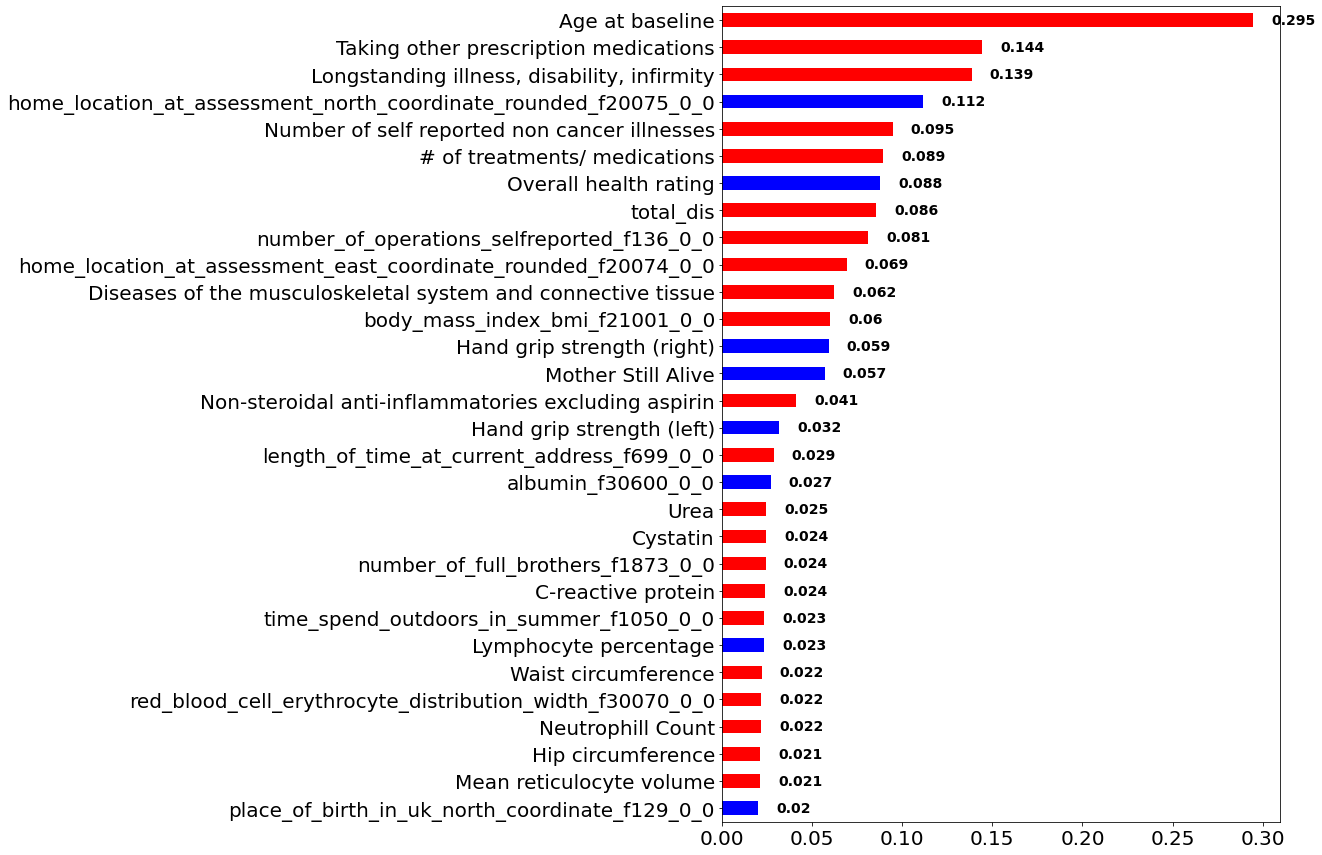

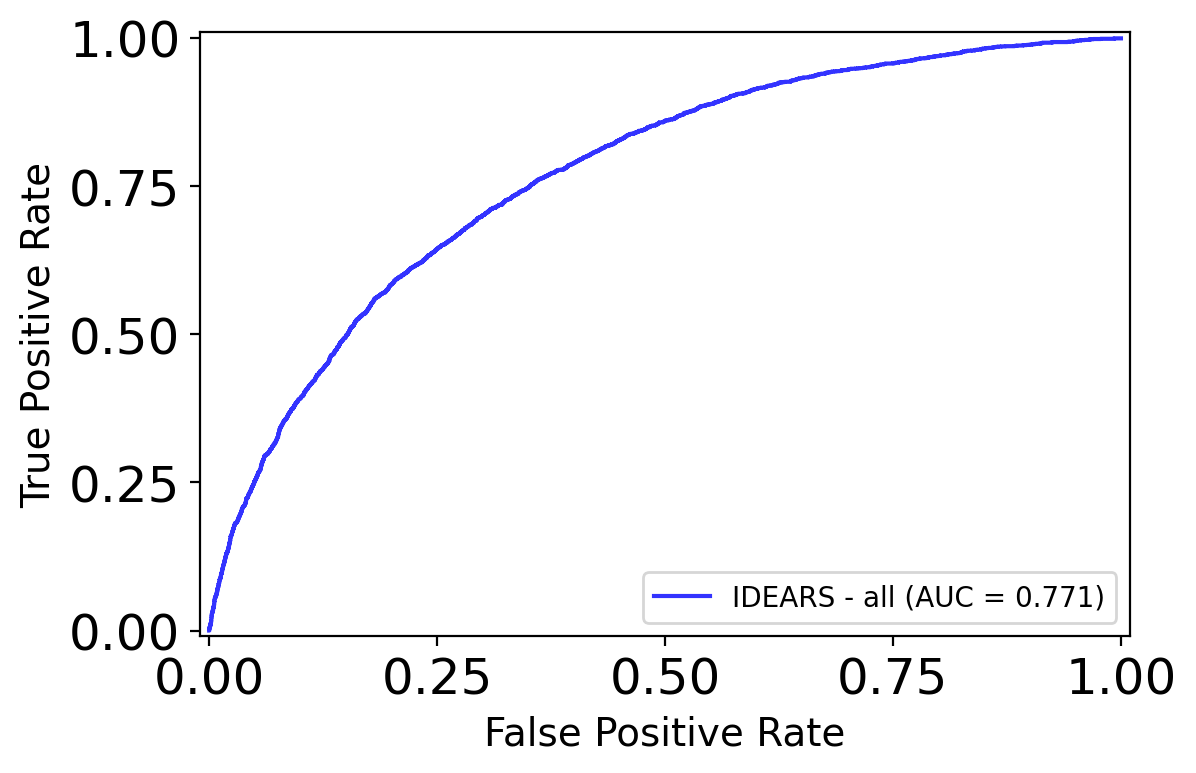

[0.7707057150351304]

In [12]:
df_arth=dp.data_merge_dis(remwords='xxxxx',disease='arthritis',icd10s=icd10s_arth,outfile=None,use_icd10=True,
                 strcont=True,bef=False,years=2)
df_arth_samp=df_arth.sample(int(round(df_arth.shape[0]/10,0)))
shap_arth=process_run(df=df_arth_samp,depvar='arthritis',resize=1,resizeratio=5,
                           remwords='time_to_arthritis')
feats_all=ml.shapgraphs_tuple(shap_arth,max_disp=30,figname='SHAP IDEARS ENTIRE COHORT Arthritis prosepctive')
ml.ROCAUC_tuples(df_out_list=[shap_arth[2]],labels=['IDEARS - all'],cols=['blue'],figname='ROCAUC for Arthritis prosepctive')

In [169]:
df_mig_full=dp.data_merge_dis(remwords='xxxxx',disease='migraine',icd10s=icd10s_mig,outfile=None,use_icd10=True,
                 strcont=True,bef=True,years=0)

0
Total ohe variables = 1 


In [154]:
#migraine headache 
mask=(df_mig[0]['time_to_migraine']>0)
df_mig1=df_mig[0].loc[mask,]

In [183]:
mask=(df_mig[0]['time_to_migraine']<-2)
df_mig2=df_mig[0].loc[mask,]
df_mig2

,eid,migraine_date,date_assess,time_to_migraine,migraine
0,1002211,2004-03-24,2009-07-27,-5.341547,-1
1,1002661,2006-12-09,2010-01-18,-3.110198,-1
5,1004878,2004-07-29,2008-01-09,-3.446954,-1
11,1007084,1999-03-30,2007-09-22,-8.481862,-1
18,1011606,2000-09-21,2008-11-13,-8.145106,-1
...,...,...,...,...,...
6794,6014021,2003-10-15,2010-05-13,-6.576318,-1
6795,6015747,2001-11-09,2010-07-09,-8.662560,-1
6807,6021292,1998-02-19,2008-03-29,-10.105407,-1
6808,6021445,2006-01-06,2010-07-02,-4.484600,-1


In [186]:
df_head_ache['migraine']=0
mask=(df_head_ache['eid'].isin(df_mig2['eid']))
df_head_ache.loc[mask,'migraine']=1
#df_mig1

In [187]:
mask=(df_mig_full['eid'].isin(df_head_ache['eid']))
df_mig_full=df_mig_full.loc[mask,]
mask=(df_mig_full['eid'].isin(df_mig2['eid']))
df_mig_full.loc[mask,'migraine']=1

Total migraine in data: 828
Total migraine in data: 828
3


<Figure size 2000x3000 with 0 Axes>

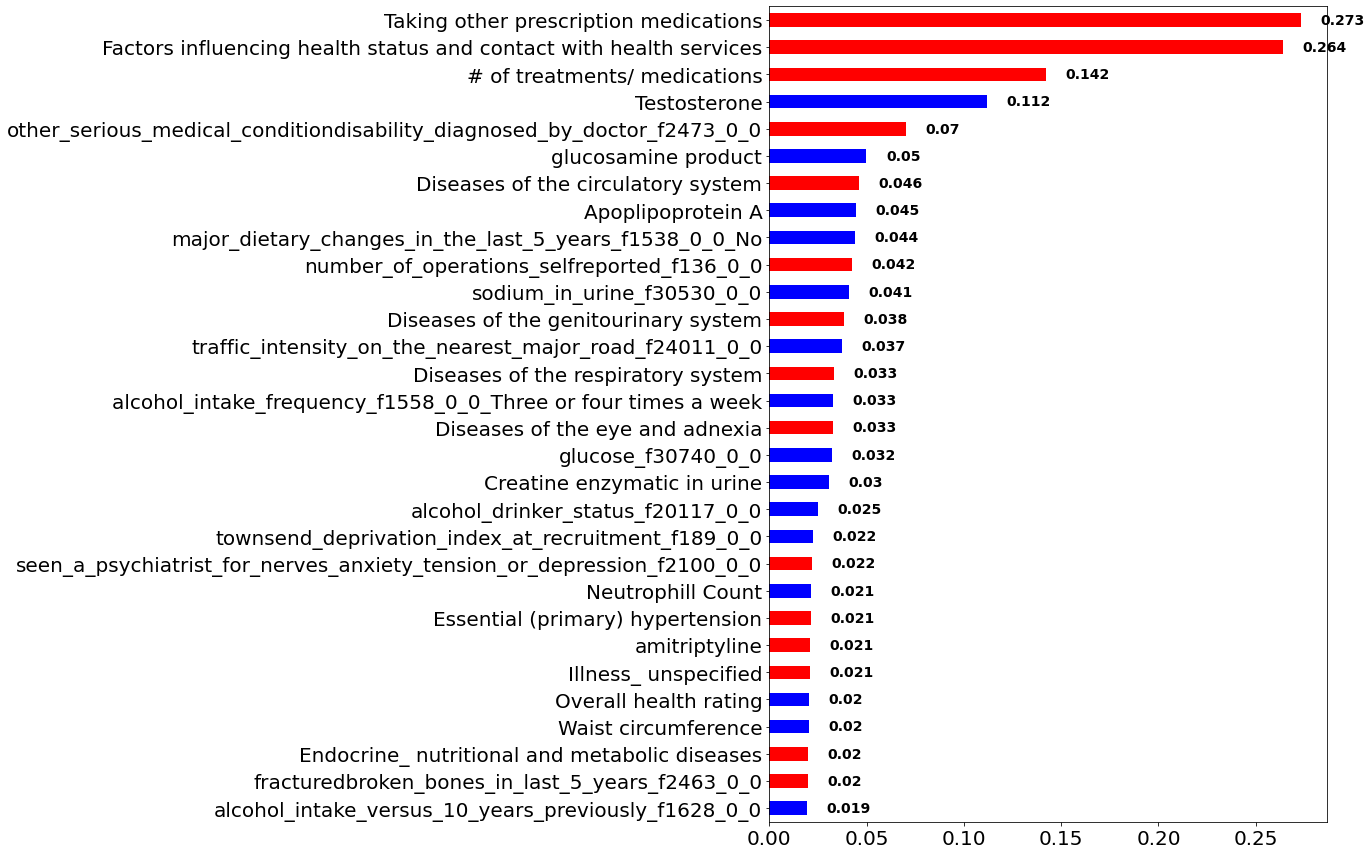

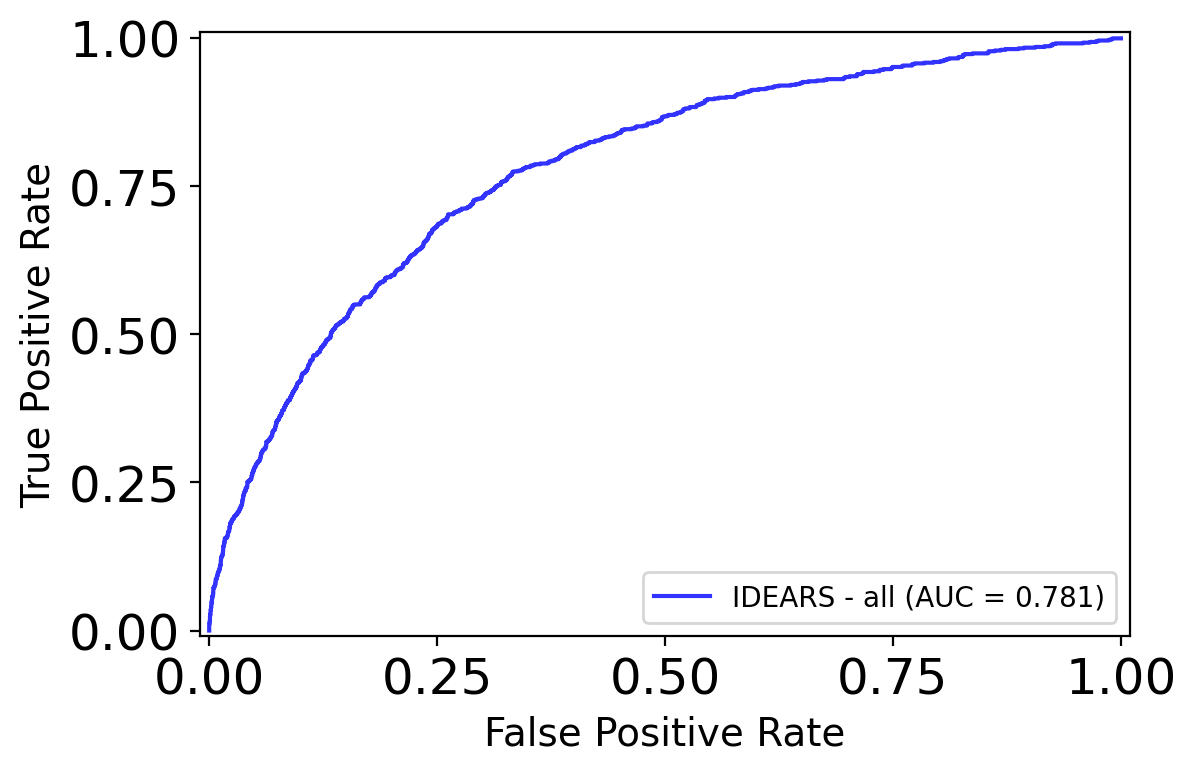

[0.780906861887092]

In [188]:
shap_diab_mig=process_run(df=df_mig_full,depvar='migraine',resize=1,resizeratio=20,
                           remwords='polyneuro|Headache|classified|illness|\
diabetes|Polyneuro|R074|R104|Pain|nervous system|pain|Migraine|time_since_migraine|musculoskeletal|total_dis')
feats_all=ml.shapgraphs_tuple(shap_diab_mig,max_disp=30,figname='SHAP IDEARS ENTIRE COHORT diabetes pain')
ml.ROCAUC_tuples(df_out_list=[shap_diab_mig[2]],labels=['IDEARS - all'],cols=['blue'],figname='ROCAUC for diabetes pain')

In [168]:
df_head_ache['migraine'].count()

102960

In [162]:
df_head_ache['migraine'].sum()

0

In [ ]:
# Experiment 1: Split migraine from headache pain for over 3 months

In [17]:
df_poly_past=df_poly.loc[df_poly['time_since_polyneuropathy']>0,]

In [47]:
df_diab3=df_diab2.loc[df_diab2['diabetes']==1,]

<AxesSubplot:>

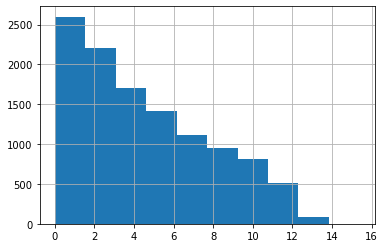

In [50]:
df_diab3['time_since_diabetes'].hist()

In [52]:
df_diab3.shape

(11391, 1732)

In [53]:
df_diab3['pain_neuro']=0
df_diab3.loc[df_diab3['eid'].isin(df_poly[1]['eid']),'pain_neuro']=1

In [57]:
df_diab3.drop(columns='time_since_diabetes',inplace=True)
df_diab3.drop(columns='diabetes',inplace=True)

In [67]:
df_diab4=df_diab3.copy()
df_diab4.drop(columns='pain_neuro',inplace=True)

In [77]:
df_diab4['PAIN']=0
df_diab4.loc[df_diab4['eid'].isin(pain_eids),'PAIN']=1

In [88]:
def remap_dic(x):
    if x in dic_icd10:
        x=dic_icd10[x]
    return x

In [90]:
df_diab4.columns=[remap_dic(c) for c in df_diab4.columns]

Total PAIN in data: 3430
Total PAIN in data: 3430
3


<Figure size 2000x3000 with 0 Axes>

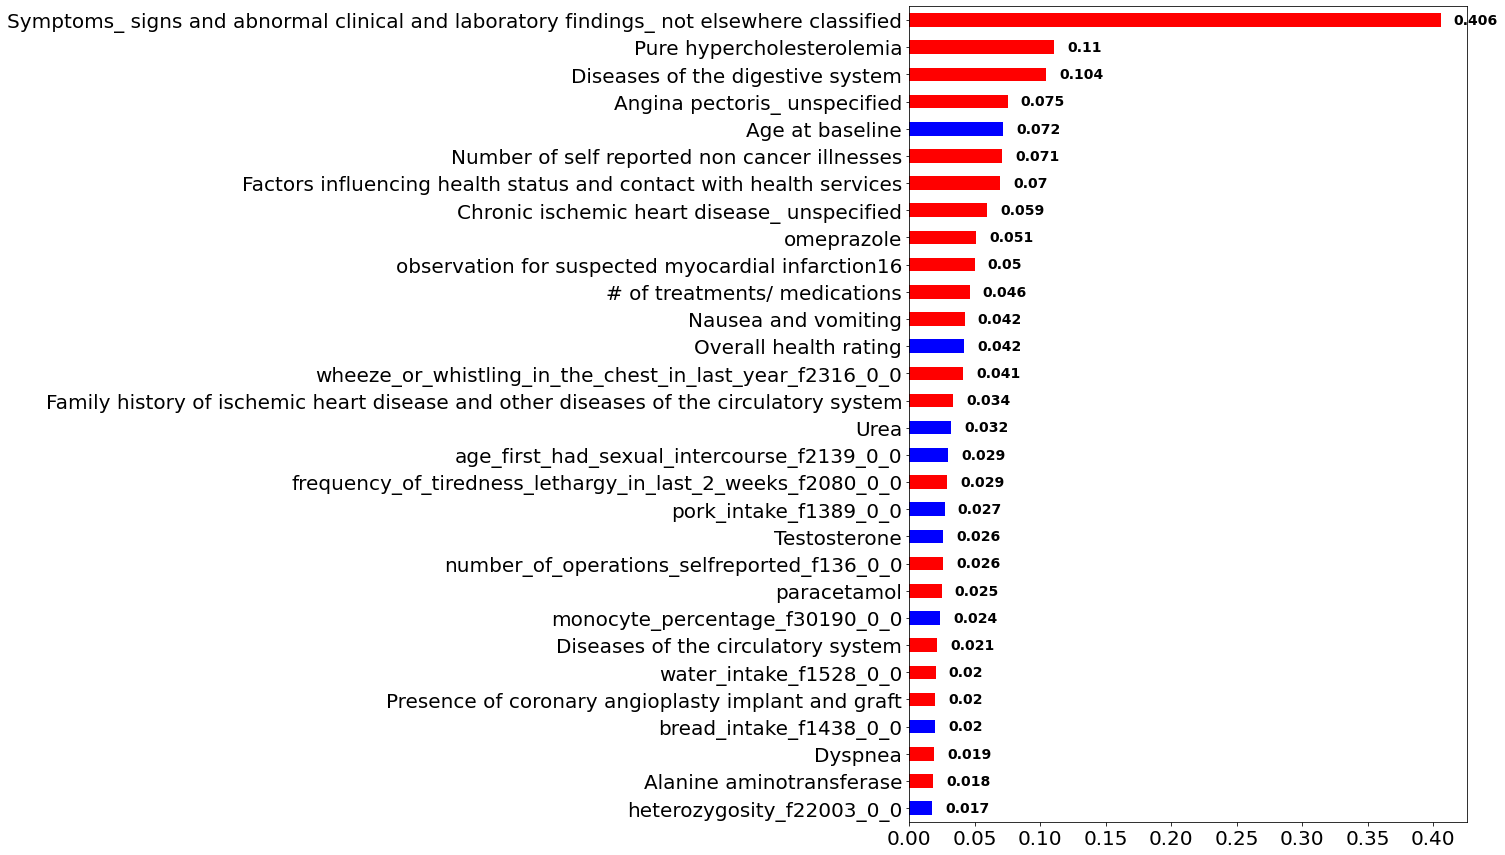

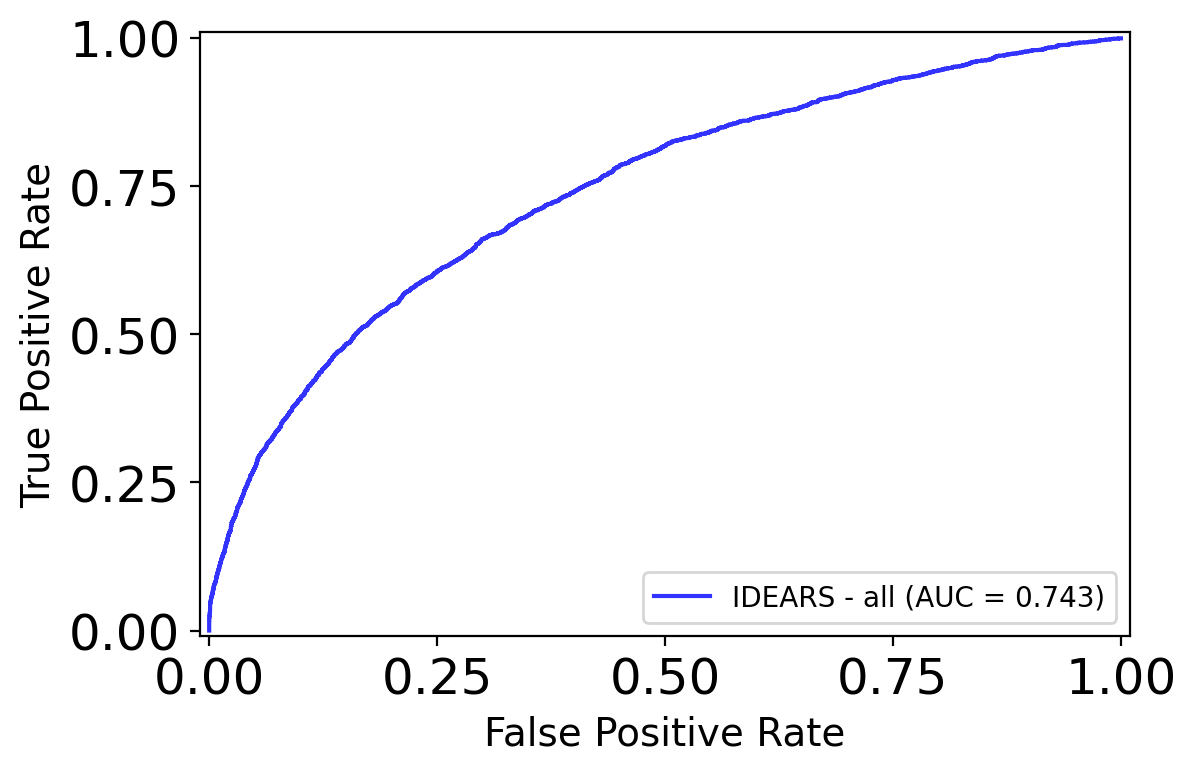

[0.7430283707165566]

In [91]:
shap_diab_pain=process_run(df=df_diab4,depvar='PAIN',resize=0,
                           remwords='polyneuro|diabetes|Polyneuro|R074|R104|Pain|pain|musculoskeletal|total_dis')
feats_all=ml.shapgraphs_tuple(shap_diab_pain,max_disp=30,figname='SHAP IDEARS ENTIRE COHORT diabetes pain')
ml.ROCAUC_tuples(df_out_list=[shap_diab_pain[2]],labels=['IDEARS - all'],cols=['blue'],figname='ROCAUC for diabetes pain')

In [96]:
df_poly1=df_poly[1].loc[df_poly[1]['time_since_polyneuropathy']>0,]

In [97]:
df_diab3['pain_neuro']=0
df_diab3.loc[df_diab3['eid'].isin(df_poly1['eid']),'pain_neuro']=1

Total pain_neuro in data: 194
Total pain_neuro in data: 194
3


<Figure size 2000x3000 with 0 Axes>

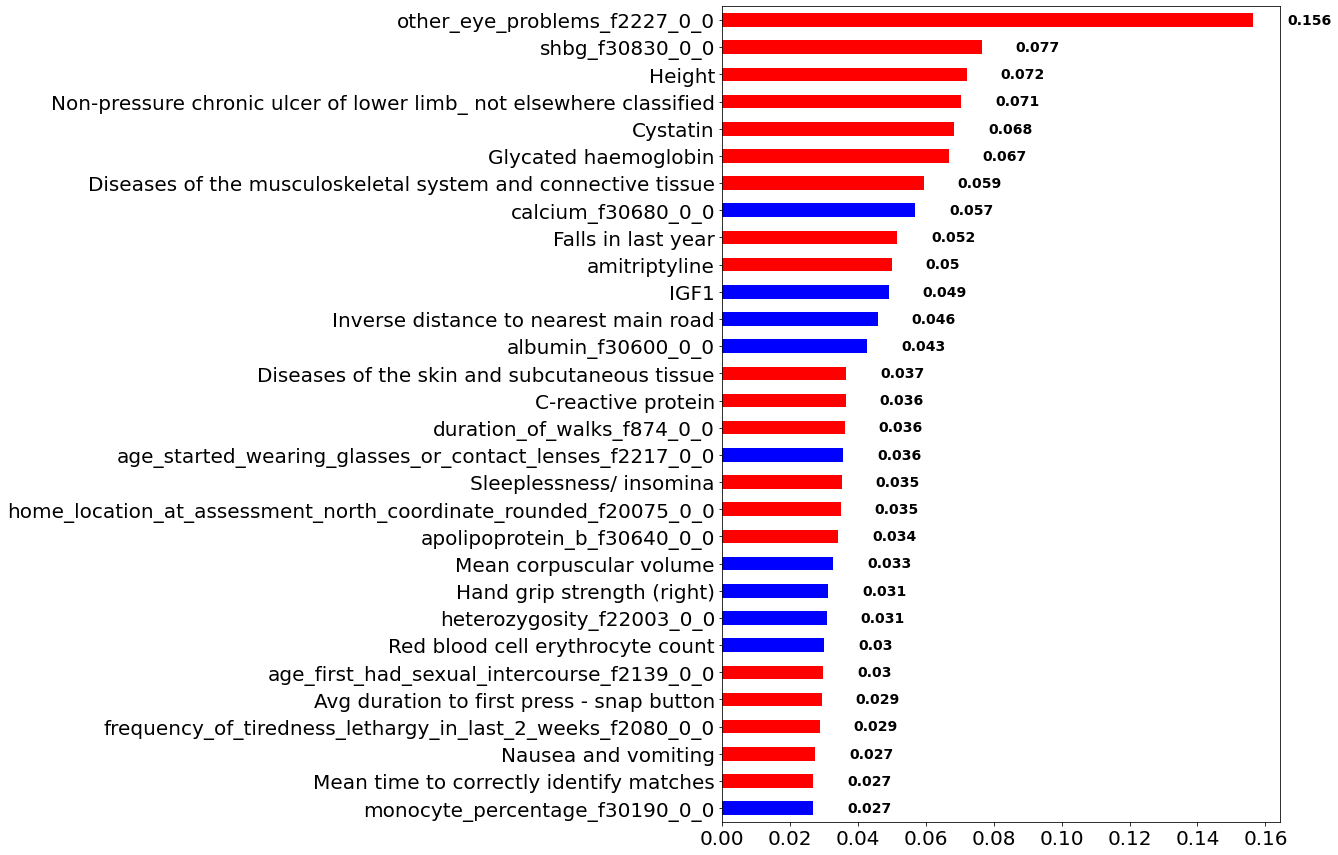

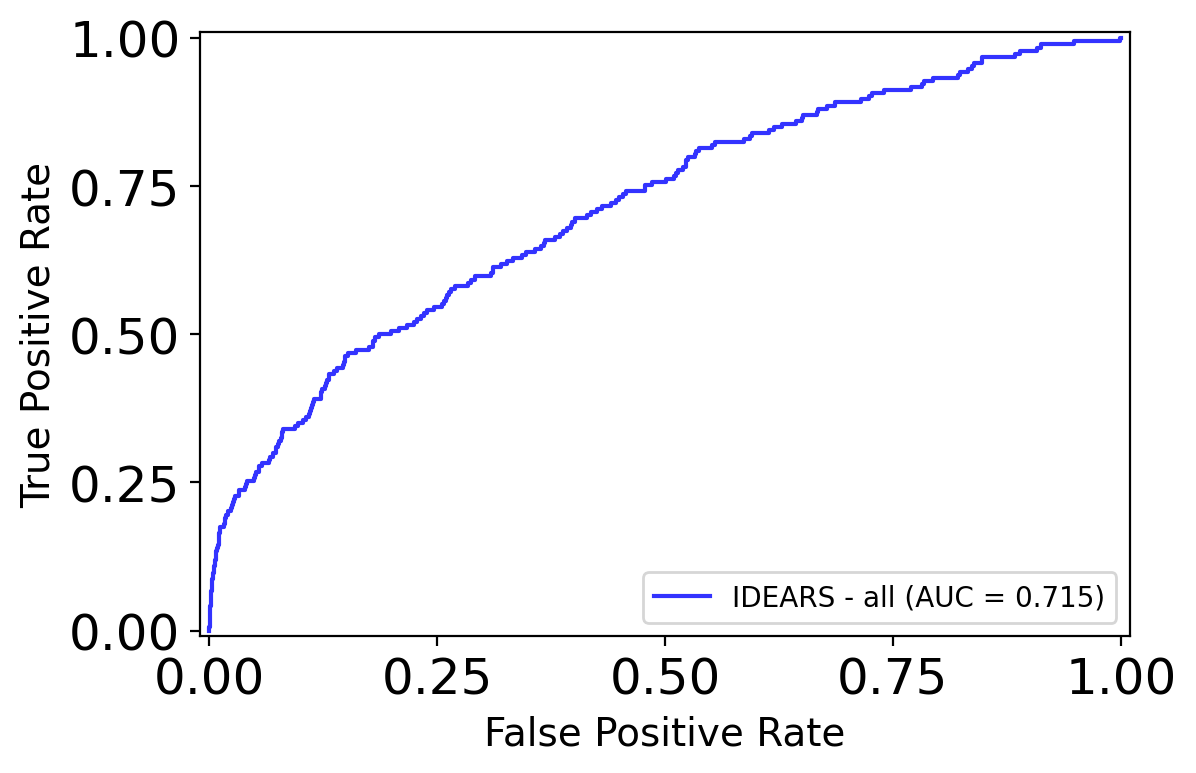

[0.7147697263013668]

In [101]:
df_diab3.columns=[remap_dic(c) for c in df_diab3.columns]
shap_diab_neu=process_run(df=df_diab3,depvar='pain_neuro',resize=0,remwords='polyneuro|diabe|Polyneuro|nervous system|total_dis|xxxx')
feats_all=ml.shapgraphs_tuple(shap_diab_neu,max_disp=30,figname='SHAP IDEARS ENTIRE COHORT diabetes pain neuro')
ml.ROCAUC_tuples(df_out_list=[shap_diab_neu[2]],labels=['IDEARS - all'],cols=['blue'],figname='ROCAUC for diabetes pain neuro')

<AxesSubplot:>

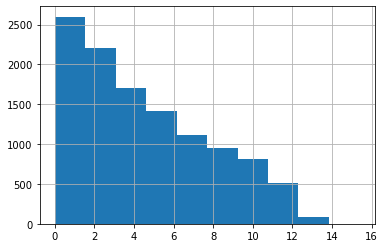

In [10]:
df_diab2['time_since_diabetes'].hist()

In [2]:
neur_ICD10s=list(np.arange(15)+50)
neur_ICD10s=['G'+str(c) for c in neur_ICD10s]
neur_ICD10s='|'.join(neur_ICD10s)

In [3]:
df=ac.read_all_samp()
paincols=['eid']+ac.findcols(df,'pain')
df_pain=pd.read_csv(ac.path+ac.inpfile,usecols=paincols)
df2=count_nulls(df_pain)
df2.to_csv(dp.path+'pain_fields.csv')

In [102]:
search_icd(strings='chronic pain',string_pat=True)[0]

'R522'

In [121]:
df_poly

,eid,polyneuropathy_date,date_assess,time_to_polyneuropathy,polyneuropathy
0,1000544,2011-05-16,2009-05-27,1.968515,-1
1,1000572,2012-04-13,2010-03-16,2.078029,1
2,1001191,2013-12-20,2008-10-29,5.141684,1
3,1001493,2007-12-12,2007-12-07,0.013689,-1
4,1001664,2019-01-18,2009-03-02,9.880903,1
...,...,...,...,...,...
4881,6021967,2019-12-13,2009-08-11,10.338125,1
4882,6022646,2019-02-06,2008-11-25,10.198494,1
4883,6023503,2021-02-06,2010-04-10,10.828200,1
4884,6024261,2009-11-19,2007-12-04,1.960301,-1


In [124]:
df_diab[0].loc[df_diab[0]['eid'].isin(df_poly['eid']),]

,eid,diabetes_date,date_assess,time_to_diabetes,diabetes
29,1003445,2013-04-30,2009-05-23,3.937029,1
37,1004162,2012-04-25,2008-08-30,3.652293,1
58,1006225,2000-02-06,2008-09-29,-8.646133,-1
89,1011360,2005-12-30,2009-07-18,-3.548255,-1
97,1012116,2018-06-19,2009-04-01,9.215606,1
...,...,...,...,...,...
42017,6004324,2011-03-29,2009-10-07,1.472964,-1
42104,6013281,2014-10-04,2008-02-06,6.658453,1
42115,6014593,1999-09-24,2009-11-02,-10.108145,-1
42116,6014782,2007-11-14,2009-05-28,-1.535934,-1


<AxesSubplot:>

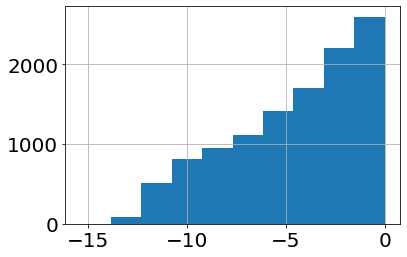

In [126]:
df_diab_new=df_diab[0].loc[df_diab[0]['diabetes_date']<df_diab[0]['date_assess'],]

NameError: name 'dp' is not defined

In [ ]:
df_diab2['diabetes'].value_counts()

In [ ]:
df_diab2['time_since_diabetes'].hist()

In [115]:
df_diab=dp.disease_labels_ICD10s2(icd10s=icd10_diabs,disease='diabetes',out='test.parquet',strcont=True,bef=False,
		years=2,outfile=False)

E119    38984
E149     5014
E109     4492
E113     3473
E114     1329
E103      900
E115      860
N083      728
E112      651
E101      479
E139      452
E143      446
E111      415
E104      347
E116      317
O244      221
E105      178
E102      163
E232      162
E110      152
E118      115
E106       78
O240       69
E144       61
E100       59
E108       57
O249       51
E141       43
E142       37
E148       37
E145       31
E146       30
N251       27
E107       18
E133       16
E117       15
O241       14
E140       14
E131       10
E136        5
E138        4
E147        3
E130        3
E135        3
E132        3
E134        3
O243        2
E137        1
Name: disease, dtype: int64


In [118]:
df_diab[1]['dis_aft'].sum()

31001

In [41]:
# check for Arthritis


In [54]:
# check for polyneuropathy
mask_p=(icd10s['disease'].str.contains('POLYNEUROPATHY'))
icd10s_poly=list(icd10s.loc[mask_p,'code'])
icd10s_poly='|'.join(icd10s_poly)

In [68]:
# check for sciatica
mask_p=(icd10s['disease'].str.contains('SCIATICA'))
icd10s_sci=list(icd10s.loc[mask_p,'code'])
icd10s_sci='|'.join(icd10s_sci)

In [70]:
# check for migraine
mask_m=(icd10s['disease'].str.contains('MIGRAINE'))
icd10s_mig=list(icd10s.loc[mask_m,'code'])
icd10s_mig='|'.join(icd10s_mig)

In [77]:
# check for pain
mask_pain=(icd10s['disease'].str.contains('PAIN'))
icd10s_pain=list(icd10s.loc[mask_pain,'code'])
dic_pain=dict(zip(icd10s.loc[mask_pain,'code'],icd10s.loc[mask_pain,'disease']))
icd10s_pain='|'.join(icd10s_pain)

In [75]:
df_pain=dp.disease_labels_ICD10s2(icd10s=icd10s_pain,disease='pain',out='test.parquet',strcont=True,bef=False,
		years=2,outfile=False)

R074     37562
R104     29217
R101     18857
R073     16333
R103     13007
         ...  
T656         3
M5467        1
M5460        1
M5468        1
M5462        1
Name: disease, Length: 73, dtype: int64


In [79]:
df_pain[1]['disease_name2']=df_pain[1]['disease'].map(dic_pain)

In [89]:
pain_df=pd.DataFrame(df_pain[1].groupby(['disease','disease_name','disease_name2'])
                     .agg({'dis_bef':['sum','count'],'dis_aft':'sum'})).reset_index()
pain_df.columns=['ICD10','old_name','new_names','total_bef_baseline','records in dataset','total_2years_aft_baseline']

In [90]:
pain_df.to_csv(dp.path_pain+'pain_list.csv')

In [91]:
icd10s_mig

'G43|G430|G431|G433|G438|G439'

In [69]:
icd10s_sci

'M543|M5430|M5432|M5435|M5436|M5437|M5438|M5439|M544|M5440|M5444|M5445|M5446|M5447|M5448|M5449'

In [60]:
df_pol=dp.disease_labels_ICD10s2(icd10s=icd10s_poly,disease='polyneur',out='test.parquet',strcont=True,bef=False,
		years=2,outfile=False)

G629    3235
G632    1239
G610     359
G620     270
G618     157
G621      60
G619      44
G633      35
G636      30
G622      26
G635      24
G634      11
G631      11
G630      10
G638       6
G611       1
Name: disease, dtype: int64


In [63]:
df_arth=dp.disease_labels_ICD10s2(icd10s=icd10s_arth,disease='arthritis',out='test.parquet',strcont=True,bef=False,
		years=2,outfile=False)

M139     15756
M1399     6756
M069      5987
M0699     3689
M1390     2400
         ...  
M0825        1
M0844        1
M0588        1
M0028        1
M0016        1
Name: disease, Length: 224, dtype: int64


In [67]:
sum(~df_arth[0]['eid'].isin(df_pol[0]['eid']))

36508

In [62]:
df_pol[0]

,eid,polyneur_date,date_assess,time_to_polyneur,polyneur
0,1000544,2011-05-16,2009-05-27,1.968515,-1
1,1000572,2012-04-13,2010-03-16,2.078029,1
2,1001191,2013-12-20,2008-10-29,5.141684,1
3,1001493,2007-12-12,2007-12-07,0.013689,-1
4,1001664,2019-01-18,2009-03-02,9.880903,1
...,...,...,...,...,...
4881,6021967,2019-12-13,2009-08-11,10.338125,1
4882,6022646,2019-02-06,2008-11-25,10.198494,1
4883,6023503,2021-02-06,2010-04-10,10.828200,1
4884,6024261,2009-11-19,2007-12-04,1.960301,-1


In [43]:
icd10s_arth='|'.join(icd10s_arth)

In [44]:
icd10s_arth

'M00|M000|M0000|M0001|M0002|M0003|M0005|M0006|M0007|M0008|M001|M0010|M0012|M0016|M002|M0020|M0023|M0024|M0025|M0026|M0027|M0029|M008|M0080|M0081|M0085|M0086|M0087|M009|M0090|M0091|M0092|M0093|M0094|M0095|M0096|M0097|M0098|M0099|M013|M0139|M018|M0187|M05|M053|M0530|M058|M0580|M0582|M0583|M0584|M0586|M0587|M0588|M0589|M059|M0590|M0591|M0592|M0593|M0594|M0595|M0596|M0597|M0598|M0599|M06|M060|M0600|M0601|M0602|M0603|M0604|M0605|M0606|M0607|M0608|M0609|M068|M0680|M0681|M0682|M0685|M0686|M0687|M0688|M0689|M069|M0690|M0691|M0692|M0693|M0694|M0695|M0696|M0697|M0698|M0699|M071|M0717|M08|M080|M0800|M0802|M0805|M0806|M0807|M0808|M0809|M082|M0822|M0829|M083|M0830|M0836|M084|M0840|M088|M0880|M089|M0890|M0896|M0899|M13|M130|M1300|M1303|M1304|M1305|M1306|M1307|M1309|M131|M1310|M1311|M1312|M1313|M1314|M1315|M1316|M1317|M1319|M138|M1380|M1381|M1382|M1383|M1384|M1385|M1386|M1387|M1389|M139|M1390|M1391|M1392|M1393|M1394|M1395|M1396|M1397|M1398|M1399|M772|M7723'

R521    1319
R522     943
Name: disease, dtype: int64
0
Total ohe variables = 1 


In [104]:
df_cp['chronic_pain'].value_counts()

0.0    466083
1.0      1545
Name: chronic_pain, dtype: int64

Total chronic_pain in data: 1545
Total chronic_pain in data: 1545
3


<Figure size 2000x3000 with 0 Axes>

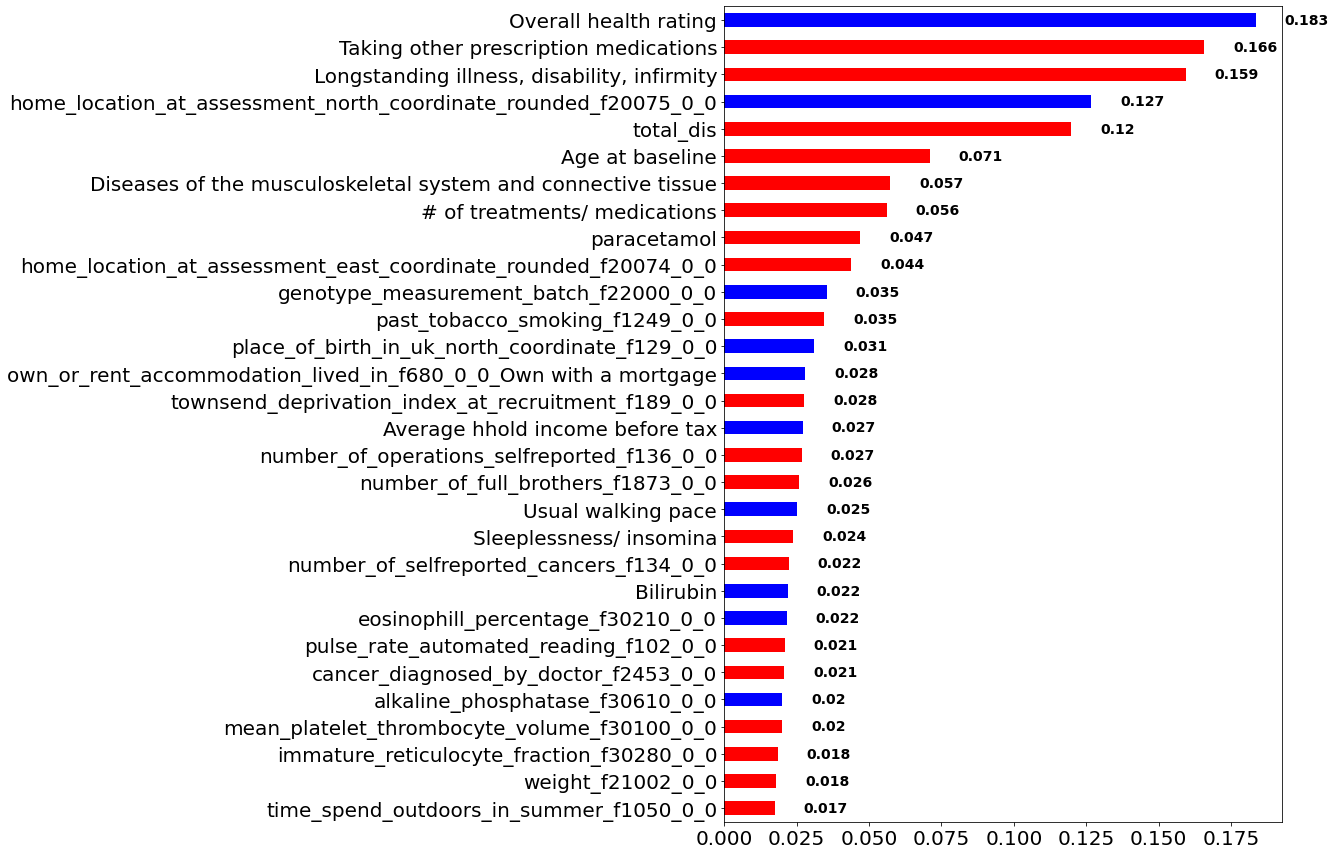

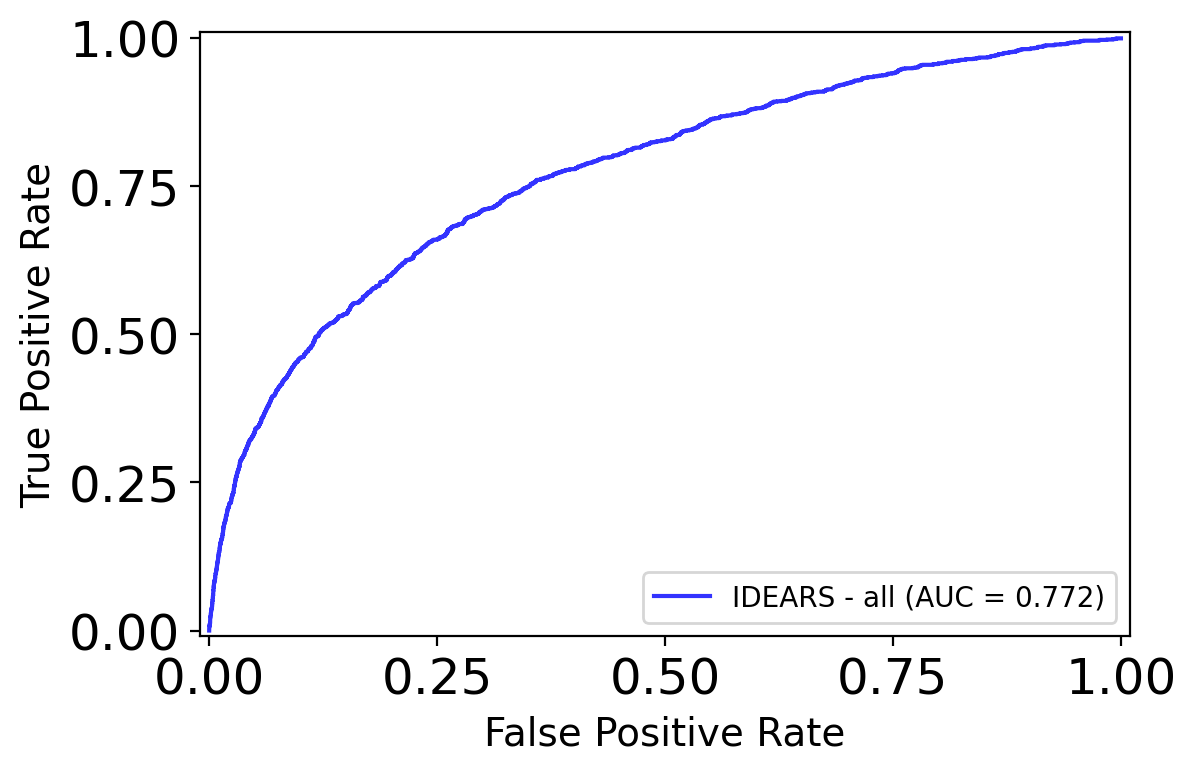

[0.7723416442387715]

In [45]:
df_arth=dp.data_merge_dis(remwords='xxxxx',disease='Arthritis',icd10s=icd10s_arth,outfile=None,use_icd10=True,
                 strcont=True)

M139     15756
M1399     6756
M069      5987
M0699     3689
M1390     2400
         ...  
M0825        1
M0844        1
M0588        1
M0028        1
M0016        1
Name: disease, Length: 224, dtype: int64
0
Total ohe variables = 1 


In [48]:
df_arth['Arthritis'].sum()

27772.0

In [17]:
myString = 'Position of a character'
myString.replace(' ','b')

'Positionbofbabcharacter'

In [27]:
import re
icd10s['code'].apply(lambda x:re.sub('.',' ',x))

0         
1         
2         
3         
4         
        ..
10260     
10261     
10262     
10263     
10264     
Name: code, Length: 10265, dtype: object

In [31]:
icd10s['code']

0          A00
1        A00.9
2          A01
3        A01.0
4        A01.1
         ...  
10260    Z98.2
10261    Z98.8
10262      Z99
10263    Z99.1
10264    Z99.2
Name: code, Length: 10265, dtype: object